In [44]:
%load_ext watermark
%watermark -u -d -v -p numpy,scipy,pyprind,tensorflow

Last updated: 2021-06-14

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.24.1

numpy     : 1.19.5
scipy     : 1.6.2
pyprind   : 2.11.2
tensorflow: 2.4.1



In [1]:
import pandas as pd
import numpy as np
import os

import gc

In [2]:
train_df = pd.read_csv('train.tsv', sep="\t")
test_df = pd.read_csv('test.tsv', sep="\t")
sub_df = pd.read_csv('sampleSubmission.csv', sep=",")

In [3]:
import seaborn as sns
from sklearn.feature_extraction import text as sktext

In [4]:
overlapped = pd.merge(train_df[["Phrase", "Sentiment"]], test_df, on="Phrase", how="inner")
overlap_boolean_mask_test = test_df['Phrase'].isin(overlapped['Phrase'])

training data phrase length distribution


/home/lab/anaconda3/envs/tensorflow/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


testing data phrase length distribution


/home/lab/anaconda3/envs/tensorflow/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Phrase', ylabel='Density'>

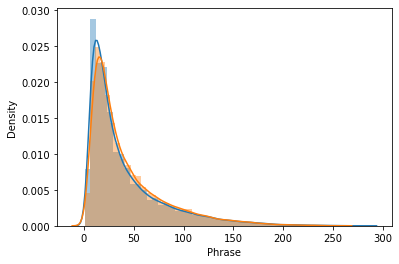

In [5]:
print("training data phrase length distribution")
sns.distplot(train_df['Phrase'].map(lambda ele: len(ele)), kde_kws={"label": "train"})

print("testing data phrase length distribution")
sns.distplot(test_df[~overlap_boolean_mask_test]['Phrase'].map(lambda ele: len(ele)), kde_kws={"label": "test"})

training and testing data sentences hist:


/home/lab/anaconda3/envs/tensorflow/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/lab/anaconda3/envs/tensorflow/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SentenceId', ylabel='Density'>

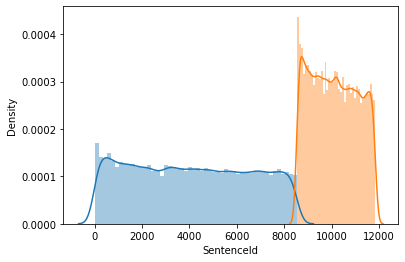

In [6]:
print("training and testing data sentences hist:")
sns.distplot(train_df['SentenceId'], kde_kws={"label": "train"})
sns.distplot(test_df['SentenceId'], kde_kws={"label": "test"})

In [7]:
print("The number of overlapped SentenceId between training and testing data:")
train_overlapped_sentence_id_df = train_df[train_df['SentenceId'].isin(test_df['SentenceId'])]
print(train_overlapped_sentence_id_df.shape[0])

del train_overlapped_sentence_id_df
gc.collect()

The number of overlapped SentenceId between training and testing data:
0


25

In [8]:
pd.options.display.max_colwidth = 250
print("Example of sentence and phrases: ")

sample_sentence_id = train_df.sample(1)['SentenceId'].values[0]
sample_sentence_group_df = train_df[train_df['SentenceId'] == sample_sentence_id]
sample_sentence_group_df

Example of sentence and phrases: 


,PhraseId,SentenceId,Phrase,Sentiment
31431,31432,1471,A tasty slice of droll whimsy .,2
31432,31433,1471,A tasty slice of droll whimsy,3
31433,31434,1471,A tasty slice,3
31434,31435,1471,tasty slice,3
31435,31436,1471,of droll whimsy,2
31436,31437,1471,droll whimsy,1
31437,31438,1471,droll,2


In [9]:
import smart_open
smart_open.open = smart_open.smart_open
import nltk
import gensim
import operator 
from keras.preprocessing import text as ktext

In [10]:
def build_vocab(texts):
    tk = ktext.Tokenizer(lower = True, filters='')
    tk.fit_on_texts(texts)
    return tk.word_counts

def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    for word in vocab.keys():
        if word in embeddings_index:
            known_words[word] = vocab[word]
            continue
        unknown_words[word] = vocab[word]

    print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
    num_known_words = np.sum(np.asarray(list(known_words.values())))
    num_unknown_words = np.sum(np.asarray(list(unknown_words.values())))
    print('Found embeddings for  {:.3%} of all text'.format(float(num_known_words) / (num_known_words + num_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [11]:
texts = list(train_df['Phrase'].values) + list(test_df['Phrase'].values)
vocab = build_vocab(texts)

In [12]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr[:len(arr)-1], dtype='float32')
    
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>15)
        
    return embeddings_index

In [13]:
DATA_ROOT='/home/lab/양창희/데이터 마이닝/기말고사'
pretrained_w2v_path = os.path.join(DATA_ROOT, "GoogleNews-vectors-negative300.bin")
w2v_google = gensim.models.KeyedVectors.load_word2vec_format(pretrained_w2v_path, binary=True).wv

pretrained_w2v_path = os.path.join(DATA_ROOT, "crawl-300d-2M.vec")
w2v_fasttext = load_embed(pretrained_w2v_path)

/home/lab/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
print("google")
unknown_vocab = check_coverage(vocab, w2v_google)
print("unknown vocabulary:")
print(unknown_vocab[:50])

print("\n")

print("fast text")
unknown_vocab = check_coverage(vocab, w2v_fasttext)
print("unknown vocabulary:")
print(unknown_vocab[:50])

google
Found embeddings for 80.907% of vocab
Found embeddings for  77.257% of all text
unknown vocabulary:
[(',', 58124), ('a', 50032), ('of', 44659), ('and', 44234), ('to', 31499), ('.', 24592), ("'s", 23541), ('--', 4666), ("'", 3797), ('-rrb-', 3348), ('-lrb-', 2853), ('...', 2504), ('``', 2306), ("''", 2298), (':', 1066), ('-', 1039), (';', 591), ('?', 533), ('mr.', 443), ('!', 284), ('sci-fi', 260), ('coming-of-age', 221), ('old-fashioned', 193), ('90', 187), ('writer-director', 179), ('niro', 176), ('2002', 171), ('spielberg', 171), ('ms.', 170), ('sandler', 163), ('10', 157), ('gross-out', 148), ('well-acted', 136), ("'70s", 130), ('soderbergh', 127), ('20', 125), ('seagal', 123), ('heavy-handed', 122), ('\\/', 118), ('thought-provoking', 116), ('low-budget', 113), ('b-movie', 113), ('self-conscious', 109), ("'60s", 109), ('after-school', 108), ('kissinger', 107), ('benigni', 106), ('well-made', 105), ('self-indulgent', 105), ('scorsese', 104)]


fast text
Found embeddings for 9

In [15]:
w2v = w2v_fasttext
# del w2v_google, w2v_fasttext, texts, vocab
# gc.collect()

In [16]:
from keras.preprocessing import sequence
import gensim
from sklearn import preprocessing as skp

In [17]:
max_len = 50
embed_size = 300
max_features = 30000

In [18]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", "n't": "not", "'ve": "have"}

In [19]:
def known_contractions(embed):
    known = []
    for contract in contraction_mapping:
        if contract in embed:
            known.append(contract)
    return known

In [20]:
known_contract_list = known_contractions(w2v)
print(known_contract_list)

["can't", "'cause", "didn't", "doesn't", "don't", "haven't", "he's", "I'd", "I'll", "I'm", "I've", "isn't", "it's", "she's", "that's", "there's", "they're", "we're", "won't", "you'll", "you're", "'ve"]


In [21]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [22]:
train_df.loc[:, 'Phrase'] = train_df['Phrase'].map(lambda text: clean_contractions(text, contraction_mapping))
test_df.loc[:, 'Phrase'] = test_df['Phrase'].map(lambda text: clean_contractions(text, contraction_mapping))

In [23]:
full_text = list(train_df['Phrase'].values) + list(test_df['Phrase'].values)
vocab = build_vocab(full_text)
check_coverage(vocab, w2v)
print("")

Found embeddings for 92.985% of vocab
Found embeddings for  98.283% of all text



In [24]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [25]:
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

In [26]:
def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

In [27]:
print(unknown_punct(w2v, punct))

_ ` 


In [28]:
train_df.loc[:, 'Phrase'] = train_df['Phrase'].map(lambda text: clean_special_chars(text, punct, punct_mapping))
test_df.loc[:, 'Phrase'] = test_df['Phrase'].map(lambda text: clean_special_chars(text, punct, punct_mapping))

In [29]:
full_text = list(train_df['Phrase'].values) + list(test_df['Phrase'].values)
vocab = build_vocab(full_text)
unknown_vocab = check_coverage(vocab, w2v)

Found embeddings for 96.485% of vocab
Found embeddings for  99.330% of all text


In [30]:
def map_unknown_token(text, dst_token, unknown_vocab_set):
#     token_list = []
#     for t in text.split(" "):
#         if t in unknown_vocab_set:
#             token_list.append(dst_token)
#         else:
#             token_list.append(t)
    
#     return " ".join(token_list)
    return' '.join([dst_token if t.lower() in unknown_vocab_set else t for t in text.split(" ")])

In [31]:
unknown_vocab_set = set(list(map(
    lambda unknown_vocab_tuple: unknown_vocab_tuple[0],
    unknown_vocab
)))
train_df.loc[:, 'Phrase'] = train_df['Phrase'].map(lambda ele: map_unknown_token(ele, "[ name ]", unknown_vocab_set))
test_df.loc[:, 'Phrase'] = test_df['Phrase'].map(lambda ele: map_unknown_token(ele, "[ name ]", unknown_vocab_set))

In [32]:
full_text = list(train_df['Phrase'].values) + list(test_df['Phrase'].values)
vocab = build_vocab(full_text)
unknown_vocab = check_coverage(vocab, w2v)
print(unknown_vocab)

Found embeddings for 100.000% of vocab
Found embeddings for  100.000% of all text
[]


In [33]:
full_text = list(train_df['Phrase'].values) + list(test_df[~overlap_boolean_mask_test]['Phrase'].values)

tk = ktext.Tokenizer(lower = True, filters='')
tk.fit_on_texts(full_text)
train_tokenized = tk.texts_to_sequences(train_df['Phrase'])
test_tokenized = tk.texts_to_sequences(test_df[~overlap_boolean_mask_test]['Phrase'])

X_train = sequence.pad_sequences(train_tokenized, maxlen = max_len)
X_test = sequence.pad_sequences(test_tokenized, maxlen = max_len)

In [34]:
word_index = tk.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = None
    if word in w2v:
        embedding_vector = w2v[word]
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
del w2v
gc.collect()

20

In [35]:
y_train = train_df['Sentiment']

led = skp.LabelEncoder()
led.fit(y_train.values)

y_train = led.transform(y_train.values)

In [36]:
X_test = X_train[100000:, :]
y_test = y_train[100000:]
X_train = X_train[:100000, :]
y_train = y_train[:100000]

In [37]:
X_train.shape, X_test.shape

((100000, 50), (56060, 50))

In [38]:
import tensorflow as tf

from keras import callbacks as kc
from keras import optimizers as ko
from keras import initializers, regularizers, constraints
from keras.engine import Layer
import keras.backend as K
from keras.preprocessing import sequence
import gensim
from sklearn import preprocessing as skp
import nltk
import gensim
import operator 
from keras.preprocessing import text as ktext
from keras.utils import model_to_dot
from keras import models
from keras import layers

import matplotlib.pyplot as plt
from IPython.display import SVG

add_weight부분에 shape로 변경해줘야댐

In [39]:
def _dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        # todo: check that this is correct
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
    
class AttentionWeight(Layer):
    """
        This code is a modified version of cbaziotis implementation:  GithubGist cbaziotis/AttentionWithContext.py
        Attention operation, with a context/query vector, for temporal data.
        Supports Masking.
        Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
        "Hierarchical Attention Networks for Document Classification"
        by using a context vector to assist the attention
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, steps)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(AttentionWeight())
        """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWeight, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
################################### shape=써줘야됨 add_weight에
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWeight, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = _dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = _dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        return a

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1]

    def get_config(self):
        config = {
            'W_regularizer': regularizers.serialize(self.W_regularizer),
            'u_regularizer': regularizers.serialize(self.u_regularizer),
            'b_regularizer': regularizers.serialize(self.b_regularizer),
            'W_constraint': constraints.serialize(self.W_constraint),
            'u_constraint': constraints.serialize(self.u_constraint),
            'b_constraint': constraints.serialize(self.b_constraint),
            'bias': self.bias
        }
        base_config = super(AttentionWeight, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [40]:
def is_integer(val):
    return isinstance(val, (int, np.int_))

def predict(keras_model, x, learning_phase=0):

    if isinstance(keras_model.input, list):
        f = backend.function(
            keras_model.input + [backend.learning_phase()],
            [keras_model.output, ]
        )
        y = f(tuple(x) + (learning_phase,))[0]
    else:
        f = backend.function(
            [keras_model.input, backend.learning_phase()],
            [keras_model.output, ]
        )
        y = f((x, learning_phase))[0]
    return y
    

def build_birnn_attention_model(
        voca_dim, time_steps, output_dim, rnn_dim, mlp_dim, 
        item_embedding=None, rnn_depth=1, mlp_depth=1, num_att_channel=1,
        drop_out=0.5, rnn_drop_out=0., rnn_state_drop_out=0.,
        trainable_embedding=False, gpu=False, return_customized_layers=False):
    """
    Create A Bidirectional Attention Model.

    :param voca_dim: vocabulary dimension size.
    :param time_steps: the length of input
    :param output_dim: the output dimension size
    :param rnn_dim: rrn dimension size
    :param mlp_dim: the dimension size of fully connected layer
    :param item_embedding: integer, numpy 2D array, or None (default=None)
        If item_embedding is a integer, connect a randomly initialized embedding matrix to the input tensor.
        If item_embedding is a matrix, this matrix will be used as the embedding matrix.
        If item_embedding is None, then connect input tensor to RNN layer directly.
    :param rnn_depth: rnn depth
    :param mlp_depth: the depth of fully connected layers
    :param num_att_channel: the number of attention channels, this can be used to mimic multi-head attention mechanism
    :param drop_out: dropout rate of fully connected layers
    :param rnn_drop_out: dropout rate of rnn layers
    :param rnn_state_drop_out: dropout rate of rnn state tensor
    :param trainable_embedding: boolean
    :param gpu: boolean, default=False
        If True, CuDNNLSTM is used instead of LSTM for RNN layer.
    :param return_customized_layers: boolean, default=False
        If True, return model and customized object dictionary, otherwise return model only
    :return: keras model
    """
    
    if item_embedding is not None:
        inputs = models.Input(shape=(time_steps,), dtype='int32', name='input0')
        x = inputs

        # item embedding
        if isinstance(item_embedding, np.ndarray):
            assert voca_dim == item_embedding.shape[0]
            x = layers.Embedding(
                voca_dim, item_embedding.shape[1], input_length=time_steps,
                weights=[item_embedding, ], trainable=trainable_embedding,
                mask_zero=False, name='embedding_layer0'
            )(x)
        elif utils.is_integer(item_embedding):
            x = layers.Embedding(
                voca_dim, item_embedding, input_length=time_steps,
                trainable=trainable_embedding,
                mask_zero=False, name='embedding_layer0'
            )(x)
        else:
            raise ValueError("item_embedding must be either integer or numpy matrix")
    else:
        inputs = models.Input(shape=(time_steps, voca_dim), dtype='float32', name='input0')
        x = inputs
    
    x = layers.SpatialDropout1D(rnn_drop_out, name='rnn_spatial_droutout_layer')(x)

    if gpu:
        # rnn encoding
        for i in range(rnn_depth):
            x = layers.Bidirectional(
                layers.LSTM(rnn_dim, return_sequences=True),
                ###LSTM으로 바꿈 CuDNNLSTM
                name='bi_lstm_layer' + str(i))(x)
            x = layers.BatchNormalization(name='rnn_batch_norm_layer' + str(i))(x)
            x = layers.Dropout(rate=rnn_drop_out, name="rnn_dropout_layer" + str(i))(x)
    else:
        # rnn encoding
        for i in range(rnn_depth):
            x = layers.Bidirectional(
                layers.LSTM(rnn_dim, return_sequences=True, dropout=rnn_drop_out, recurrent_dropout=rnn_state_drop_out),
                name='bi_lstm_layer' + str(i))(x)
            x = layers.BatchNormalization(name='rnn_batch_norm_layer' + str(i))(x)

    # attention
    attention_heads = []
    x_per = layers.Permute((2, 1), name='permuted_attention_x')(x)
    for h in range(max(1, num_att_channel)):
        attention = AttentionWeight(name="attention_weights_layer" + str(h))(x)
        xx = layers.Dot([2, 1], name='focus_head' + str(h) + '_layer0')([x_per, attention])
        attention_heads.append(xx)

    if num_att_channel > 1:
        x = layers.Concatenate(name='focus_layer0')(attention_heads)
    else:
        x = attention_heads[0]

    x = layers.BatchNormalization(name='focused_batch_norm_layer')(x)
    x = layers.Dropout(rate=rnn_drop_out, name="focused_dropout_layer")(x)

    # MLP Layers
    for i in range(mlp_depth - 1):
        x = layers.Dense(mlp_dim, activation='selu', kernel_initializer='lecun_normal', name='selu_layer' + str(i))(x)
        x = layers.AlphaDropout(drop_out, name='alpha_layer' + str(i))(x)

    outputs = layers.Dense(output_dim, activation="softmax", name="softmax_layer0")(x)

    model = models.Model(inputs, outputs)

    if return_customized_layers:
        return model, {'AttentionWeight': AttentionWeight}
    return model


def build_cnn_model(
        voca_dim, time_steps, output_dim, mlp_dim, num_filters, filter_sizes,
        item_embedding=None, mlp_depth=1,
        drop_out=0.5, cnn_drop_out=0.5, pooling='max', padding='valid',
        trainable_embedding=False, return_customized_layers=False):
    """
    Create A CNN Model.

    :param voca_dim: vocabulary dimension size.
    :param time_steps: the length of input
    :param output_dim: the output dimension size
    :param num_filters: list of integers
        The number of filters.
    :param filter_sizes: list of integers
        The kernel size.
    :param mlp_dim: the dimension size of fully connected layer
    :param item_embedding: integer, numpy 2D array, or None (default=None)
        If item_embedding is a integer, connect a randomly initialized embedding matrix to the input tensor.
        If item_embedding is a matrix, this matrix will be used as the embedding matrix.
        If item_embedding is None, then connect input tensor to RNN layer directly.
    :param mlp_depth: the depth of fully connected layers
    :param drop_out: dropout rate of fully connected layers
    :param cnn_drop_out: dropout rate of between cnn layer and fully connected layers
    :param pooling: str, either 'max' or 'average'
        Pooling method.
    :param padding: One of "valid", "causal" or "same" (case-insensitive).
        Padding method.
    :param trainable_embedding: boolean
    :param return_customized_layers: boolean, default=False
        If True, return model and customized object dictionary, otherwise return model only
    :return: keras model
    """

    if item_embedding is not None:
        inputs = models.Input(shape=(time_steps,), dtype='int32', name='input0')
        x = inputs

        # item embedding
        if isinstance(item_embedding, np.ndarray):
            assert voca_dim == item_embedding.shape[0]
            x = layers.Embedding(
                voca_dim, item_embedding.shape[1], input_length=time_steps,
                weights=[item_embedding, ], trainable=trainable_embedding,
                mask_zero=False, name='embedding_layer0'
            )(x)
        elif utils.is_integer(item_embedding):
            x = layers.Embedding(
                voca_dim, item_embedding, input_length=time_steps,
                trainable=trainable_embedding,
                mask_zero=False, name='embedding_layer0'
            )(x)
        else:
            raise ValueError("item_embedding must be either integer or numpy matrix")
    else:
        inputs = models.Input(shape=(time_steps, voca_dim), dtype='float32', name='input0')
        x = inputs
    
    x = layers.SpatialDropout1D(cnn_drop_out, name='cnn_spatial_droutout_layer')(x)

    pooled_outputs = []
    for i in range(len(filter_sizes)):
        conv = layers.Conv1D(num_filters[i], kernel_size=filter_sizes[i], padding=padding, activation='relu')(x)
        if pooling == 'max':
            conv = layers.GlobalMaxPooling1D(name='global_pooling_layer' + str(i))(conv)
        else:
            conv = layers.GlobalAveragePooling1D(name='global_pooling_layer' + str(i))(conv)
        pooled_outputs.append(conv)

    x = layers.Concatenate(name='concated_layer')(pooled_outputs)
    x = layers.Dropout(cnn_drop_out, name='conv_dropout_layer')(x)
    x = layers.BatchNormalization(name="batch_norm_layer")(x)

    # MLP Layers
    for i in range(mlp_depth - 1):
        x = layers.Dense(mlp_dim, activation='selu', kernel_initializer='lecun_normal', name='selu_layer' + str(i))(x)
        x = layers.AlphaDropout(drop_out, name='alpha_layer' + str(i))(x)

    outputs = layers.Dense(output_dim, activation="softmax", name="softmax_layer0")(x)

    model = models.Model(inputs, outputs)

    if return_customized_layers:
        return model, dict()

    return model


def build_birnn_cnn_model(
        voca_dim, time_steps, output_dim, rnn_dim, mlp_dim, num_filters, filter_sizes,
        item_embedding=None, rnn_depth=1, mlp_depth=1,
        drop_out=0.5, rnn_drop_out=0.5, rnn_state_drop_out=0.5, cnn_drop_out=0.5, pooling='max', padding='valid',
        trainable_embedding=False, gpu=False, return_customized_layers=False):
    """
    Create A Bidirectional CNN Model.

    :param voca_dim: vocabulary dimension size.
    :param time_steps: the length of input
    :param output_dim: the output dimension size
    :param rnn_dim: rrn dimension size
    :param num_filters: list of integers
        The number of filters.
    :param filter_sizes: list of integers
        The kernel size.
    :param mlp_dim: the dimension size of fully connected layer
    :param item_embedding: integer, numpy 2D array, or None (default=None)
        If item_embedding is a integer, connect a randomly initialized embedding matrix to the input tensor.
        If item_embedding is a matrix, this matrix will be used as the embedding matrix.
        If item_embedding is None, then connect input tensor to RNN layer directly.
    :param rnn_depth: rnn depth
    :param mlp_depth: the depth of fully connected layers
    :param num_att_channel: the number of attention channels, this can be used to mimic multi-head attention mechanism
    :param drop_out: dropout rate of fully connected layers
    :param rnn_drop_out: dropout rate of rnn layers
    :param rnn_state_drop_out: dropout rate of rnn state tensor
    :param cnn_drop_out: dropout rate of between cnn layer and fully connected layers
    :param pooling: str, either 'max' or 'average'
        Pooling method.
    :param padding: One of "valid", "causal" or "same" (case-insensitive).
        Padding method.
    :param trainable_embedding: boolean
    :param gpu: boolean, default=False
        If True, CuDNNLSTM is used instead of LSTM for RNN layer.
    :param return_customized_layers: boolean, default=False
        If True, return model and customized object dictionary, otherwise return model only
    :return: keras model
    """

    if item_embedding is not None:
        inputs = models.Input(shape=(time_steps,), dtype='int32', name='input0')
        x = inputs

        # item embedding
        if isinstance(item_embedding, np.ndarray):
            assert voca_dim == item_embedding.shape[0]
            x = layers.Embedding(
                voca_dim, item_embedding.shape[1], input_length=time_steps,
                weights=[item_embedding, ], trainable=trainable_embedding,
                mask_zero=False, name='embedding_layer0'
            )(x)
        elif utils.is_integer(item_embedding):
            x = layers.Embedding(
                voca_dim, item_embedding, input_length=time_steps,
                trainable=trainable_embedding,
                mask_zero=False, name='embedding_layer0'
            )(x)
        else:
            raise ValueError("item_embedding must be either integer or numpy matrix")
    else:
        inputs = models.Input(shape=(time_steps, voca_dim), dtype='float32', name='input0')
        x = inputs
        
    x = layers.SpatialDropout1D(rnn_drop_out, name='rnn_spatial_droutout_layer')(x)

    if gpu:
        # rnn encoding
        for i in range(rnn_depth):
            x = layers.Bidirectional(
                layers.LSTM(rnn_dim, return_sequences=True),
                name='bi_lstm_layer' + str(i))(x)
            x = layers.BatchNormalization(name='rnn_batch_norm_layer' + str(i))(x)
            x = layers.Dropout(rate=rnn_drop_out, name="rnn_dropout_layer" + str(i))(x)
    else:
        # rnn encoding
        for i in range(rnn_depth):
            x = layers.Bidirectional(
                layers.LSTM(rnn_dim, return_sequences=True, dropout=rnn_drop_out, recurrent_dropout=rnn_state_drop_out),
                name='bi_lstm_layer' + str(i))(x)
            x = layers.BatchNormalization(name='rnn_batch_norm_layer' + str(i))(x)

    pooled_outputs = []
    for i in range(len(filter_sizes)):
        conv = layers.Conv1D(num_filters[i], kernel_size=filter_sizes[i], padding=padding, activation='relu')(x)
        if pooling == 'max':
            conv = layers.GlobalMaxPooling1D(name='global_pooling_layer' + str(i))(conv)
        else:
            conv = layers.GlobalAveragePooling1D(name='global_pooling_layer' + str(i))(conv)
        pooled_outputs.append(conv)

    x = layers.Concatenate(name='concated_layer')(pooled_outputs)
    x = layers.BatchNormalization(name="batch_norm_layer")(x)
    x = layers.Dropout(cnn_drop_out, name='conv_dropout_layer')(x)

    # MLP Layers
    for i in range(mlp_depth - 1):
        x = layers.Dense(mlp_dim, activation='selu', kernel_initializer='lecun_normal', name='selu_layer' + str(i))(x)
        x = layers.AlphaDropout(drop_out, name='alpha_layer' + str(i))(x)

    outputs = layers.Dense(output_dim, activation="softmax", name="softmax_layer0")(x)

    model = models.Model(inputs, outputs)

    if return_customized_layers:
        return model, dict()

    return model

def build_birnn_hierarchy_cnn_model(
        voca_dim, time_steps, output_dim, rnn_dim, mlp_dim, num_filters, filter_sizes, 
        dilation_rates=1, strides=1,
        item_embedding=None, rnn_depth=1, mlp_depth=1,
        drop_out=0.5, rnn_drop_out=0.5, rnn_state_drop_out=0.5, cnn_drop_out=0.5, pooling='max', padding='valid',
        trainable_embedding=False, gpu=False, return_customized_layers=False):
    """
    Create A Bidirectional CNN Model.

    :param voca_dim: vocabulary dimension size.
    :param time_steps: the length of input
    :param output_dim: the output dimension size
    :param rnn_dim: rrn dimension size
    :param num_filters: list of integers
        The number of filters.
    :param filter_sizes: list of integers
        The kernel size.
    :param mlp_dim: the dimension size of fully connected layer
    :param item_embedding: integer, numpy 2D array, or None (default=None)
        If item_embedding is a integer, connect a randomly initialized embedding matrix to the input tensor.
        If item_embedding is a matrix, this matrix will be used as the embedding matrix.
        If item_embedding is None, then connect input tensor to RNN layer directly.
    :param rnn_depth: rnn depth
    :param mlp_depth: the depth of fully connected layers
    :param num_att_channel: the number of attention channels, this can be used to mimic multi-head attention mechanism
    :param drop_out: dropout rate of fully connected layers
    :param rnn_drop_out: dropout rate of rnn layers
    :param rnn_state_drop_out: dropout rate of rnn state tensor
    :param cnn_drop_out: dropout rate of between cnn layer and fully connected layers
    :param pooling: str, either 'max' or 'average'
        Pooling method.
    :param padding: One of "valid", "causal" or "same" (case-insensitive).
        Padding method.
    :param trainable_embedding: boolean
    :param gpu: boolean, default=False
        If True, CuDNNLSTM is used instead of LSTM for RNN layer.
    :param return_customized_layers: boolean, default=False
        If True, return model and customized object dictionary, otherwise return model only
    :return: keras model
    """

    if item_embedding is not None:
        inputs = models.Input(shape=(time_steps,), dtype='int32', name='input0')
        x = inputs

        # item embedding
        if isinstance(item_embedding, np.ndarray):
            assert voca_dim == item_embedding.shape[0]
            x = layers.Embedding(
                voca_dim, item_embedding.shape[1], input_length=time_steps,
                weights=[item_embedding, ], trainable=trainable_embedding,
                mask_zero=False, name='embedding_layer0'
            )(x)
        elif utils.is_integer(item_embedding):
            x = layers.Embedding(
                voca_dim, item_embedding, input_length=time_steps,
                trainable=trainable_embedding,
                mask_zero=False, name='embedding_layer0'
            )(x)
        else:
            raise ValueError("item_embedding must be either integer or numpy matrix")
    else:
        inputs = models.Input(shape=(time_steps, voca_dim), dtype='float32', name='input0')
        x = inputs
        
    x = layers.SpatialDropout1D(rnn_drop_out, name='rnn_spatial_droutout_layer')(x)

    if gpu:
        # rnn encoding
        for i in range(rnn_depth):
            x = layers.Bidirectional(
                layers.LSTM(rnn_dim, return_sequences=True),
                name='bi_lstm_layer' + str(i))(x)
            x = layers.BatchNormalization(name='rnn_batch_norm_layer' + str(i))(x)
            x = layers.Dropout(rate=rnn_drop_out, name="rnn_dropout_layer" + str(i))(x)
    else:
        # rnn encoding
        for i in range(rnn_depth):
            x = layers.Bidirectional(
                layers.LSTM(rnn_dim, return_sequences=True, dropout=rnn_drop_out, recurrent_dropout=rnn_state_drop_out),
                name='bi_lstm_layer' + str(i))(x)
            x = layers.BatchNormalization(name='rnn_batch_norm_layer' + str(i))(x)

    for i in range(len(filter_sizes)):
        if is_integer(dilation_rates):
            di_rate = dilation_rates
        else:
            di_rate = dilation_rates[i]
        
        if is_integer(strides):
            std = strides
        else:
            std = strides[i]
            
        x = layers.Conv1D(num_filters[i], kernel_size=filter_sizes[i], padding=padding, activation='relu', dilation_rate=di_rate, strides=std)(x)
        
    if pooling == 'max':
        x = layers.GlobalMaxPooling1D(name='global_pooling_layer')(x)
    else:
        x = layers.GlobalAveragePooling1D(name='global_pooling_layer')(x)

    x = layers.BatchNormalization(name="batch_norm_layer")(x)
    x = layers.Dropout(cnn_drop_out, name='conv_dropout_layer')(x)

    # MLP Layers
    for i in range(mlp_depth - 1):
        x = layers.Dense(mlp_dim, activation='selu', kernel_initializer='lecun_normal', name='selu_layer' + str(i))(x)
        x = layers.AlphaDropout(drop_out, name='alpha_layer' + str(i))(x)

    outputs = layers.Dense(output_dim, activation="softmax", name="softmax_layer0")(x)

    model = models.Model(inputs, outputs)

    if return_customized_layers:
        return model, dict()

    return model

In [41]:
# make_hyperParameter
rnn_dim=[50,100,150]
mlp_dim=[50,100,150]
rnn_depth=[1,2,3]
mlp_depth=[1,2,3]

In [42]:
def build_model_CNN1(x,y,z,w):
    voca_dim = embedding_matrix.shape[0]
    time_steps = 50
    output_dim = 5
    rnn_dim = x
    mlp_dim = y
    item_embedding = embedding_matrix
    rnn_depth=z
    mlp_depth = w
    num_att_channel = 1
    cnn_drop_out = 0.5
    rnn_drop_out = 0.
    rnn_state_drop_out = 0.
    trainable_embedding=False
    return_customized_layers=False
    num_filters = [128, 128, 128]
    filter_sizes = [1, 3, 5]
    mlp_drop_out = 0.2
    padding = 'causal'
    gpu=True
    
    return build_cnn_model(
        voca_dim, time_steps, output_dim, mlp_dim, num_filters ,filter_sizes,
        item_embedding=item_embedding, mlp_depth=mlp_depth,
        drop_out=0.5,cnn_drop_out=0.5,pooling='max',padding='valid',
        trainable_embedding=trainable_embedding, return_customized_layers=return_customized_layers)

Epoch 1/20
35/35 [==============================] - 2s 54ms/step - loss: 1.8456 - acc: 0.3679 - val_loss: 1.2398 - val_acc: 0.5822
Epoch 2/20
35/35 [==============================] - 2s 49ms/step - loss: 1.3269 - acc: 0.5311 - val_loss: 1.0786 - val_acc: 0.6034
Epoch 3/20
35/35 [==============================] - 2s 49ms/step - loss: 1.1458 - acc: 0.5714 - val_loss: 1.0199 - val_acc: 0.5960
Epoch 4/20
35/35 [==============================] - 2s 49ms/step - loss: 1.0410 - acc: 0.5968 - val_loss: 0.9944 - val_acc: 0.5913
Epoch 5/20
35/35 [==============================] - 2s 49ms/step - loss: 0.9953 - acc: 0.6047 - val_loss: 0.9743 - val_acc: 0.5953
Epoch 6/20
35/35 [==============================] - 2s 49ms/step - loss: 0.9652 - acc: 0.6131 - val_loss: 0.9662 - val_acc: 0.5944
Epoch 7/20
35/35 [==============================] - 2s 49ms/step - loss: 0.9423 - acc: 0.6204 - val_loss: 0.9544 - val_acc: 0.5966
Epoch 8/20
35/35 [==============================] - 2s 49ms/step - loss: 0.9279 - a

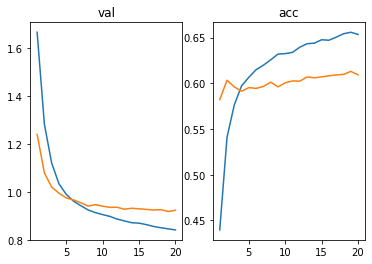

1752/1752 [==============================] - 3s 1ms/step - loss: 0.9308 - acc: 0.6078
Epoch 1/20
35/35 [==============================] - 2s 55ms/step - loss: 1.8991 - acc: 0.3303 - val_loss: 1.2920 - val_acc: 0.5601
Epoch 2/20
35/35 [==============================] - 2s 50ms/step - loss: 1.4006 - acc: 0.4829 - val_loss: 1.0517 - val_acc: 0.5991
Epoch 3/20
35/35 [==============================] - 2s 49ms/step - loss: 1.1624 - acc: 0.5475 - val_loss: 1.1568 - val_acc: 0.5926
Epoch 4/20
35/35 [==============================] - 2s 50ms/step - loss: 1.0532 - acc: 0.5798 - val_loss: 1.1961 - val_acc: 0.5957
Epoch 5/20
35/35 [==============================] - 2s 50ms/step - loss: 1.0070 - acc: 0.5959 - val_loss: 1.2690 - val_acc: 0.5922
Epoch 6/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9702 - acc: 0.6056 - val_loss: 1.2529 - val_acc: 0.5993
Epoch 7/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9477 - acc: 0.6112 - val_loss: 1.2410 - val_acc: 0.60

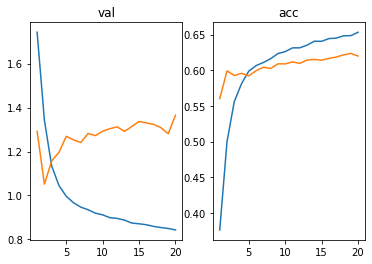

1752/1752 [==============================] - 3s 1ms/step - loss: 1.0678 - acc: 0.5932
Epoch 1/20
35/35 [==============================] - 2s 55ms/step - loss: 1.9922 - acc: 0.2876 - val_loss: 1.9806 - val_acc: 0.5012
Epoch 2/20
35/35 [==============================] - 2s 50ms/step - loss: 1.5194 - acc: 0.4315 - val_loss: 1.4896 - val_acc: 0.5920
Epoch 3/20
35/35 [==============================] - 2s 50ms/step - loss: 1.2678 - acc: 0.5160 - val_loss: 1.7359 - val_acc: 0.6001
Epoch 4/20
35/35 [==============================] - 2s 50ms/step - loss: 1.1216 - acc: 0.5583 - val_loss: 1.8420 - val_acc: 0.5930
Epoch 5/20
35/35 [==============================] - 2s 50ms/step - loss: 1.0397 - acc: 0.5851 - val_loss: 1.7756 - val_acc: 0.5957
Epoch 6/20
35/35 [==============================] - 2s 50ms/step - loss: 1.0015 - acc: 0.5959 - val_loss: 1.7529 - val_acc: 0.5990
Epoch 7/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9686 - acc: 0.6063 - val_loss: 1.7944 - val_acc: 0.59

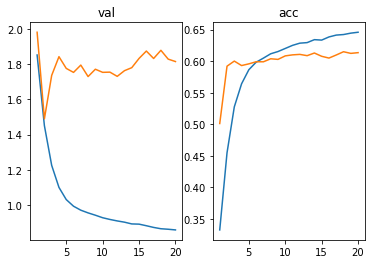

1752/1752 [==============================] - 3s 1ms/step - loss: 1.5327 - acc: 0.5855
Epoch 1/20
35/35 [==============================] - 2s 55ms/step - loss: 1.8626 - acc: 0.3460 - val_loss: 1.2183 - val_acc: 0.5810
Epoch 2/20
35/35 [==============================] - 2s 50ms/step - loss: 1.3305 - acc: 0.5302 - val_loss: 1.0702 - val_acc: 0.6019
Epoch 3/20
35/35 [==============================] - 2s 50ms/step - loss: 1.1430 - acc: 0.5702 - val_loss: 1.0177 - val_acc: 0.5945
Epoch 4/20
35/35 [==============================] - 2s 50ms/step - loss: 1.0462 - acc: 0.5937 - val_loss: 0.9941 - val_acc: 0.5932
Epoch 5/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9883 - acc: 0.6123 - val_loss: 0.9758 - val_acc: 0.5945
Epoch 6/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9652 - acc: 0.6159 - val_loss: 0.9685 - val_acc: 0.5902
Epoch 7/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9491 - acc: 0.6188 - val_loss: 0.9555 - val_acc: 0.59

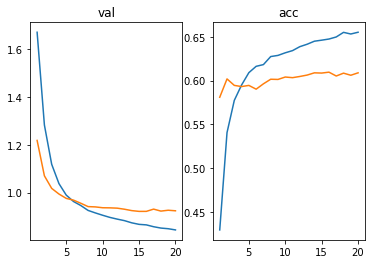

1752/1752 [==============================] - 3s 1ms/step - loss: 0.9328 - acc: 0.6039
Epoch 1/20
35/35 [==============================] - 2s 55ms/step - loss: 1.9231 - acc: 0.3310 - val_loss: 1.3964 - val_acc: 0.5403
Epoch 2/20
35/35 [==============================] - 2s 50ms/step - loss: 1.4167 - acc: 0.4771 - val_loss: 1.0335 - val_acc: 0.6052
Epoch 3/20
35/35 [==============================] - 2s 50ms/step - loss: 1.1974 - acc: 0.5429 - val_loss: 1.1229 - val_acc: 0.5982
Epoch 4/20
35/35 [==============================] - 2s 50ms/step - loss: 1.0733 - acc: 0.5745 - val_loss: 1.1848 - val_acc: 0.5952
Epoch 5/20
35/35 [==============================] - 2s 50ms/step - loss: 1.0069 - acc: 0.5964 - val_loss: 1.2339 - val_acc: 0.5965
Epoch 6/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9709 - acc: 0.6090 - val_loss: 1.2578 - val_acc: 0.5976
Epoch 7/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9503 - acc: 0.6095 - val_loss: 1.2635 - val_acc: 0.60

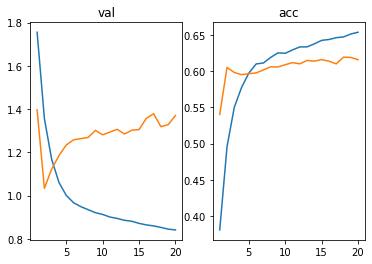

1752/1752 [==============================] - 3s 1ms/step - loss: 1.0599 - acc: 0.5977
Epoch 1/20
35/35 [==============================] - 2s 56ms/step - loss: 2.0241 - acc: 0.2827 - val_loss: 1.9240 - val_acc: 0.5207
Epoch 2/20
35/35 [==============================] - 2s 50ms/step - loss: 1.5327 - acc: 0.4363 - val_loss: 1.4870 - val_acc: 0.6006
Epoch 3/20
35/35 [==============================] - 2s 50ms/step - loss: 1.2508 - acc: 0.5220 - val_loss: 1.6808 - val_acc: 0.5962
Epoch 4/20
35/35 [==============================] - 2s 50ms/step - loss: 1.1040 - acc: 0.5647 - val_loss: 1.6475 - val_acc: 0.5953
Epoch 5/20
35/35 [==============================] - 2s 50ms/step - loss: 1.0349 - acc: 0.5832 - val_loss: 1.5442 - val_acc: 0.5988
Epoch 6/20
35/35 [==============================] - 2s 50ms/step - loss: 1.0012 - acc: 0.5960 - val_loss: 1.5517 - val_acc: 0.5994
Epoch 7/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9784 - acc: 0.6052 - val_loss: 1.5656 - val_acc: 0.60

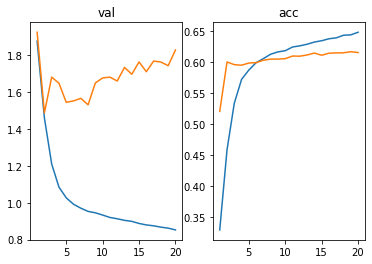

1752/1752 [==============================] - 3s 2ms/step - loss: 1.5340 - acc: 0.5946
Epoch 1/20
35/35 [==============================] - 2s 55ms/step - loss: 1.8427 - acc: 0.3686 - val_loss: 1.2265 - val_acc: 0.5890
Epoch 2/20
35/35 [==============================] - 2s 50ms/step - loss: 1.3178 - acc: 0.5344 - val_loss: 1.0744 - val_acc: 0.6031
Epoch 3/20
35/35 [==============================] - 2s 50ms/step - loss: 1.1445 - acc: 0.5708 - val_loss: 1.0208 - val_acc: 0.5930
Epoch 4/20
35/35 [==============================] - 2s 50ms/step - loss: 1.0501 - acc: 0.5927 - val_loss: 0.9953 - val_acc: 0.5912
Epoch 5/20
35/35 [==============================] - 2s 50ms/step - loss: 1.0036 - acc: 0.6035 - val_loss: 0.9786 - val_acc: 0.5901
Epoch 6/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9597 - acc: 0.6194 - val_loss: 0.9636 - val_acc: 0.5941
Epoch 7/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9496 - acc: 0.6160 - val_loss: 0.9578 - val_acc: 0.59

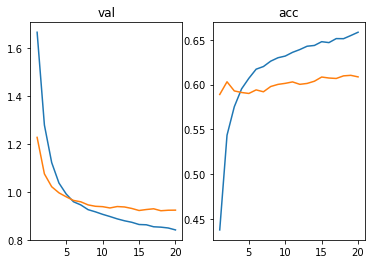

1752/1752 [==============================] - 3s 1ms/step - loss: 0.9355 - acc: 0.6014
Epoch 1/20
35/35 [==============================] - 2s 56ms/step - loss: 1.8888 - acc: 0.3354 - val_loss: 1.4044 - val_acc: 0.5297
Epoch 2/20
35/35 [==============================] - 2s 50ms/step - loss: 1.4028 - acc: 0.4805 - val_loss: 1.0382 - val_acc: 0.6026
Epoch 3/20
35/35 [==============================] - 2s 50ms/step - loss: 1.1916 - acc: 0.5434 - val_loss: 1.1101 - val_acc: 0.5963
Epoch 4/20
35/35 [==============================] - 2s 50ms/step - loss: 1.0726 - acc: 0.5768 - val_loss: 1.1819 - val_acc: 0.5945
Epoch 5/20
35/35 [==============================] - 2s 50ms/step - loss: 1.0087 - acc: 0.5932 - val_loss: 1.2313 - val_acc: 0.5952
Epoch 6/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9720 - acc: 0.6031 - val_loss: 1.2464 - val_acc: 0.6009
Epoch 7/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9493 - acc: 0.6149 - val_loss: 1.2138 - val_acc: 0.60

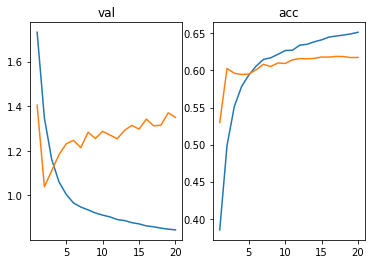

1752/1752 [==============================] - 3s 1ms/step - loss: 1.0593 - acc: 0.5966
Epoch 1/20
35/35 [==============================] - 2s 56ms/step - loss: 1.9588 - acc: 0.2812 - val_loss: 1.8882 - val_acc: 0.5116
Epoch 2/20
35/35 [==============================] - 2s 50ms/step - loss: 1.4857 - acc: 0.4421 - val_loss: 1.4651 - val_acc: 0.6001
Epoch 3/20
35/35 [==============================] - 2s 50ms/step - loss: 1.2215 - acc: 0.5280 - val_loss: 1.6577 - val_acc: 0.5961
Epoch 4/20
35/35 [==============================] - 2s 50ms/step - loss: 1.0787 - acc: 0.5714 - val_loss: 1.7019 - val_acc: 0.5900
Epoch 5/20
35/35 [==============================] - 2s 50ms/step - loss: 1.0162 - acc: 0.5930 - val_loss: 1.6935 - val_acc: 0.5917
Epoch 6/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9858 - acc: 0.6021 - val_loss: 1.6349 - val_acc: 0.5981
Epoch 7/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9651 - acc: 0.6102 - val_loss: 1.6034 - val_acc: 0.60

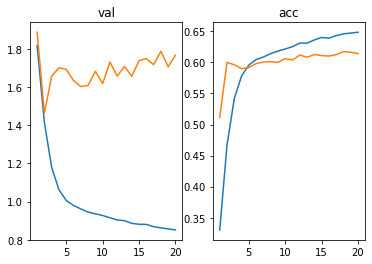

1752/1752 [==============================] - 3s 2ms/step - loss: 1.5045 - acc: 0.5922


In [56]:
for i in rnn_depth:
    for j in mlp_depth:
        model=build_model_CNN1(50,100,i,j)
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
        callback_list = [ModelCheckpoint(filepath='sentiment_rnn_checkpoint.h5',
                                 monitor='val_loss', 
                                 save_best_only=True), 
                 TensorBoard(log_dir="sentiment_rnn_logs/{}".format(
                     time.asctime()))]
        history = model.fit(X_train, y_train, 
                    batch_size=2048, epochs=20, 
                    validation_split=0.3, callbacks=callback_list)
        print("rnn_depth = ",i,"mlp_depth = ",j)
        fig=plt.figure()
        ax1=fig.add_subplot(1,2,1)
        ax2=fig.add_subplot(1,2,2)
        epochs = np.arange(1, 21)
        ax1.plot(epochs, history.history['loss'])
        ax1.plot(epochs, history.history['val_loss'])
        ax2.plot(epochs, history.history['acc'])
        ax2.plot(epochs, history.history['val_acc'])
        ax1.set_title('val')
        ax2.set_title('acc')
        plt.show()
        model.load_weights('sentiment_rnn_checkpoint.h5')
        model.evaluate(X_test, y_test)

In [61]:
num_filters=[[32,32,32],[64,64,64],[128,128,128]]
filter_sizes = [[1,2,3],[1,3,5],[1,2,4]]
cnn_drop_out = [0.,0.1,0.2]
rnn_drop_out = [0.,0.1,0.2]

In [63]:
def build_model3(x,y,z,w):
    voca_dim = embedding_matrix.shape[0]
    time_steps = 50
    output_dim = 5
    rnn_dim = 50
    mlp_dim = 100
    item_embedding = embedding_matrix
    rnn_depth=1
    mlp_depth = 1
    num_filters = x
    filter_sizes = y
    cnn_drop_out = z
    rnn_drop_out = w
    rnn_state_drop_out = 0.3
    mlp_drop_out = 0.2
    padding = 'causal'
    gpu=True
    
    return build_birnn_cnn_model(
        voca_dim, time_steps, output_dim, rnn_dim, mlp_dim, num_filters, filter_sizes, 
        item_embedding=embedding_matrix, rnn_depth=rnn_depth, mlp_depth=mlp_depth,
        rnn_drop_out=rnn_drop_out, rnn_state_drop_out=rnn_state_drop_out, cnn_drop_out=cnn_drop_out,
        padding=padding,
        gpu=gpu, return_customized_layers=True
    )

Epoch 1/20
35/35 [==============================] - 4s 73ms/step - loss: 1.5304 - acc: 0.4379 - val_loss: 1.3039 - val_acc: 0.5062
Epoch 2/20
35/35 [==============================] - 2s 56ms/step - loss: 1.0749 - acc: 0.6268 - val_loss: 1.2483 - val_acc: 0.5000
Epoch 3/20
35/35 [==============================] - 2s 55ms/step - loss: 0.9286 - acc: 0.6660 - val_loss: 1.3038 - val_acc: 0.5000
Epoch 4/20
35/35 [==============================] - 2s 56ms/step - loss: 0.8349 - acc: 0.6861 - val_loss: 1.3787 - val_acc: 0.5000
Epoch 5/20
35/35 [==============================] - 2s 56ms/step - loss: 0.7683 - acc: 0.7026 - val_loss: 1.3887 - val_acc: 0.5000
Epoch 6/20
35/35 [==============================] - 2s 56ms/step - loss: 0.7301 - acc: 0.7142 - val_loss: 1.4189 - val_acc: 0.5000
Epoch 7/20
35/35 [==============================] - 2s 56ms/step - loss: 0.6940 - acc: 0.7273 - val_loss: 1.4371 - val_acc: 0.5001
Epoch 8/20
35/35 [==============================] - 2s 56ms/step - loss: 0.6574 - a

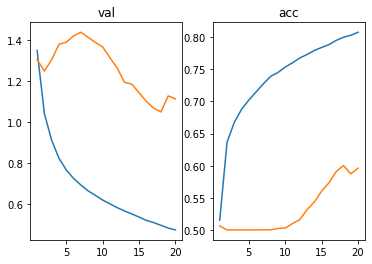

1752/1752 [==============================] - 6s 3ms/step - loss: 1.0652 - acc: 0.5925
Epoch 1/20
35/35 [==============================] - 4s 73ms/step - loss: 1.5987 - acc: 0.4336 - val_loss: 1.2761 - val_acc: 0.5003
Epoch 2/20
35/35 [==============================] - 2s 57ms/step - loss: 1.1260 - acc: 0.6003 - val_loss: 1.2650 - val_acc: 0.5000
Epoch 3/20
35/35 [==============================] - 2s 57ms/step - loss: 1.0055 - acc: 0.6308 - val_loss: 1.3559 - val_acc: 0.5000
Epoch 4/20
35/35 [==============================] - 2s 57ms/step - loss: 0.9215 - acc: 0.6466 - val_loss: 1.4286 - val_acc: 0.5000
Epoch 5/20
35/35 [==============================] - 2s 57ms/step - loss: 0.8629 - acc: 0.6592 - val_loss: 1.4636 - val_acc: 0.5000
Epoch 6/20
35/35 [==============================] - 2s 57ms/step - loss: 0.8352 - acc: 0.6662 - val_loss: 1.4665 - val_acc: 0.5000
Epoch 7/20
35/35 [==============================] - 2s 57ms/step - loss: 0.8137 - acc: 0.6724 - val_loss: 1.4956 - val_acc: 0.50

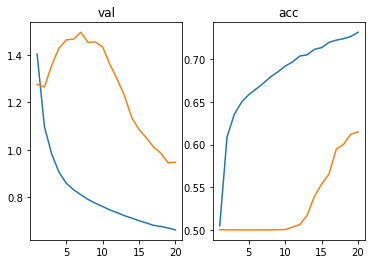

1752/1752 [==============================] - 6s 3ms/step - loss: 0.9635 - acc: 0.6047
Epoch 1/20
35/35 [==============================] - 4s 73ms/step - loss: 1.6046 - acc: 0.4386 - val_loss: 1.3045 - val_acc: 0.5006
Epoch 2/20
35/35 [==============================] - 2s 57ms/step - loss: 1.1449 - acc: 0.5930 - val_loss: 1.3348 - val_acc: 0.5000
Epoch 3/20
35/35 [==============================] - 2s 57ms/step - loss: 1.0183 - acc: 0.6227 - val_loss: 1.4375 - val_acc: 0.5000
Epoch 4/20
35/35 [==============================] - 2s 57ms/step - loss: 0.9469 - acc: 0.6328 - val_loss: 1.4843 - val_acc: 0.5000
Epoch 5/20
35/35 [==============================] - 2s 57ms/step - loss: 0.9051 - acc: 0.6405 - val_loss: 1.5413 - val_acc: 0.5000
Epoch 6/20
35/35 [==============================] - 2s 57ms/step - loss: 0.8752 - acc: 0.6441 - val_loss: 1.4952 - val_acc: 0.5000
Epoch 7/20
35/35 [==============================] - 2s 57ms/step - loss: 0.8595 - acc: 0.6510 - val_loss: 1.4980 - val_acc: 0.50

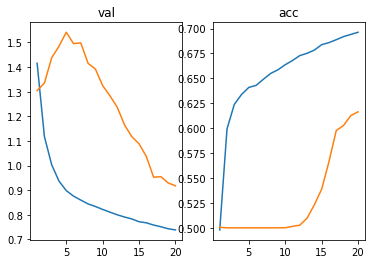

1752/1752 [==============================] - 6s 3ms/step - loss: 0.9381 - acc: 0.6108
Epoch 1/20
35/35 [==============================] - 4s 73ms/step - loss: 1.6179 - acc: 0.4170 - val_loss: 1.3478 - val_acc: 0.5014
Epoch 2/20
35/35 [==============================] - 2s 57ms/step - loss: 1.1317 - acc: 0.6046 - val_loss: 1.3315 - val_acc: 0.5000
Epoch 3/20
35/35 [==============================] - 2s 57ms/step - loss: 0.9979 - acc: 0.6417 - val_loss: 1.4008 - val_acc: 0.5000
Epoch 4/20
35/35 [==============================] - 2s 57ms/step - loss: 0.8992 - acc: 0.6647 - val_loss: 1.4792 - val_acc: 0.5000
Epoch 5/20
35/35 [==============================] - 2s 56ms/step - loss: 0.8320 - acc: 0.6790 - val_loss: 1.5500 - val_acc: 0.5000
Epoch 6/20
35/35 [==============================] - 2s 57ms/step - loss: 0.7873 - acc: 0.6929 - val_loss: 1.5621 - val_acc: 0.5000
Epoch 7/20
35/35 [==============================] - 2s 57ms/step - loss: 0.7506 - acc: 0.7034 - val_loss: 1.5326 - val_acc: 0.50

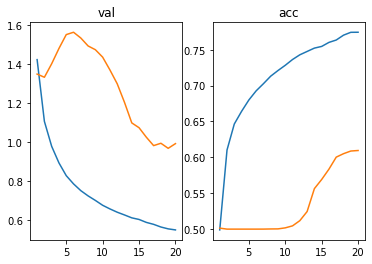

1752/1752 [==============================] - 6s 3ms/step - loss: 0.9941 - acc: 0.6002
Epoch 1/20
35/35 [==============================] - 4s 74ms/step - loss: 1.6619 - acc: 0.4043 - val_loss: 1.2921 - val_acc: 0.5004
Epoch 2/20
35/35 [==============================] - 2s 57ms/step - loss: 1.1682 - acc: 0.5885 - val_loss: 1.3086 - val_acc: 0.5000
Epoch 3/20
35/35 [==============================] - 2s 57ms/step - loss: 1.0447 - acc: 0.6204 - val_loss: 1.4091 - val_acc: 0.5000
Epoch 4/20
35/35 [==============================] - 2s 57ms/step - loss: 0.9568 - acc: 0.6370 - val_loss: 1.5131 - val_acc: 0.5000
Epoch 5/20
35/35 [==============================] - 2s 57ms/step - loss: 0.9091 - acc: 0.6429 - val_loss: 1.5706 - val_acc: 0.5000
Epoch 6/20
35/35 [==============================] - 2s 57ms/step - loss: 0.8665 - acc: 0.6527 - val_loss: 1.5767 - val_acc: 0.5000
Epoch 7/20
35/35 [==============================] - 2s 57ms/step - loss: 0.8496 - acc: 0.6586 - val_loss: 1.5723 - val_acc: 0.50

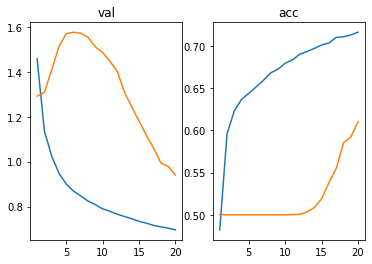

1752/1752 [==============================] - 6s 3ms/step - loss: 0.9562 - acc: 0.6056
Epoch 1/20
35/35 [==============================] - 4s 74ms/step - loss: 1.7318 - acc: 0.3889 - val_loss: 1.3357 - val_acc: 0.5242
Epoch 2/20
35/35 [==============================] - 2s 57ms/step - loss: 1.2079 - acc: 0.5698 - val_loss: 1.2870 - val_acc: 0.5104
Epoch 3/20
35/35 [==============================] - 2s 57ms/step - loss: 1.0852 - acc: 0.6001 - val_loss: 1.2853 - val_acc: 0.5049
Epoch 4/20
35/35 [==============================] - 2s 57ms/step - loss: 1.0099 - acc: 0.6174 - val_loss: 1.2933 - val_acc: 0.5035
Epoch 5/20
35/35 [==============================] - 2s 58ms/step - loss: 0.9517 - acc: 0.6277 - val_loss: 1.2872 - val_acc: 0.5037
Epoch 6/20
35/35 [==============================] - 2s 57ms/step - loss: 0.9228 - acc: 0.6334 - val_loss: 1.2670 - val_acc: 0.5051
Epoch 7/20
35/35 [==============================] - 2s 57ms/step - loss: 0.9056 - acc: 0.6380 - val_loss: 1.2617 - val_acc: 0.50

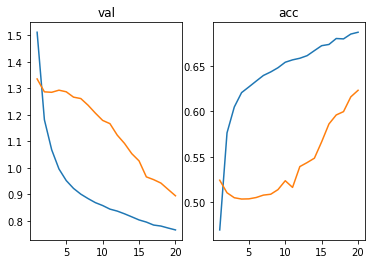

1752/1752 [==============================] - 6s 3ms/step - loss: 0.9101 - acc: 0.6176
Epoch 1/20
35/35 [==============================] - 6s 75ms/step - loss: 1.7817 - acc: 0.3763 - val_loss: 1.3264 - val_acc: 0.5173
Epoch 2/20
35/35 [==============================] - 2s 57ms/step - loss: 1.1673 - acc: 0.5837 - val_loss: 1.2440 - val_acc: 0.5005
Epoch 3/20
35/35 [==============================] - 2s 57ms/step - loss: 1.0259 - acc: 0.6275 - val_loss: 1.2442 - val_acc: 0.5000
Epoch 4/20
35/35 [==============================] - 2s 56ms/step - loss: 0.9319 - acc: 0.6520 - val_loss: 1.3008 - val_acc: 0.5000
Epoch 5/20
35/35 [==============================] - 2s 57ms/step - loss: 0.8690 - acc: 0.6675 - val_loss: 1.3353 - val_acc: 0.5000
Epoch 6/20
35/35 [==============================] - 2s 57ms/step - loss: 0.8290 - acc: 0.6778 - val_loss: 1.3777 - val_acc: 0.5000
Epoch 7/20
35/35 [==============================] - 2s 57ms/step - loss: 0.7933 - acc: 0.6858 - val_loss: 1.4068 - val_acc: 0.50

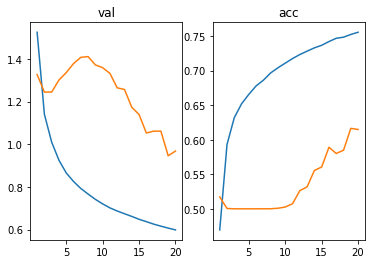

1752/1752 [==============================] - 6s 3ms/step - loss: 0.9688 - acc: 0.6084
Epoch 1/20
35/35 [==============================] - 4s 76ms/step - loss: 1.7199 - acc: 0.3943 - val_loss: 1.3415 - val_acc: 0.5007
Epoch 2/20
35/35 [==============================] - 2s 57ms/step - loss: 1.2329 - acc: 0.5683 - val_loss: 1.3444 - val_acc: 0.5000
Epoch 3/20
35/35 [==============================] - 2s 57ms/step - loss: 1.0891 - acc: 0.6086 - val_loss: 1.3961 - val_acc: 0.5000
Epoch 4/20
35/35 [==============================] - 2s 58ms/step - loss: 1.0085 - acc: 0.6273 - val_loss: 1.4290 - val_acc: 0.5000
Epoch 5/20
35/35 [==============================] - 2s 57ms/step - loss: 0.9548 - acc: 0.6341 - val_loss: 1.4273 - val_acc: 0.5000
Epoch 6/20
35/35 [==============================] - 2s 58ms/step - loss: 0.9087 - acc: 0.6446 - val_loss: 1.4311 - val_acc: 0.5000
Epoch 7/20
35/35 [==============================] - 2s 58ms/step - loss: 0.8817 - acc: 0.6491 - val_loss: 1.4224 - val_acc: 0.50

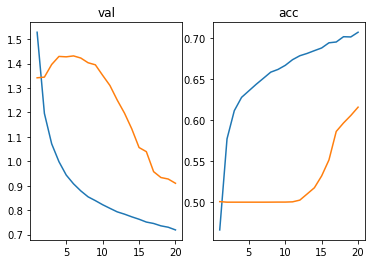

1752/1752 [==============================] - 6s 3ms/step - loss: 0.9236 - acc: 0.6111
Epoch 1/20
35/35 [==============================] - 4s 76ms/step - loss: 1.7599 - acc: 0.3835 - val_loss: 1.2942 - val_acc: 0.5012
Epoch 2/20
35/35 [==============================] - 2s 58ms/step - loss: 1.2694 - acc: 0.5519 - val_loss: 1.2513 - val_acc: 0.5000
Epoch 3/20
35/35 [==============================] - 2s 57ms/step - loss: 1.1222 - acc: 0.5938 - val_loss: 1.3241 - val_acc: 0.5000
Epoch 4/20
35/35 [==============================] - 2s 58ms/step - loss: 1.0400 - acc: 0.6123 - val_loss: 1.3575 - val_acc: 0.5000
Epoch 5/20
35/35 [==============================] - 2s 57ms/step - loss: 0.9893 - acc: 0.6190 - val_loss: 1.3793 - val_acc: 0.5000
Epoch 6/20
35/35 [==============================] - 2s 58ms/step - loss: 0.9535 - acc: 0.6253 - val_loss: 1.4168 - val_acc: 0.5000
Epoch 7/20
35/35 [==============================] - 2s 57ms/step - loss: 0.9268 - acc: 0.6328 - val_loss: 1.3929 - val_acc: 0.50

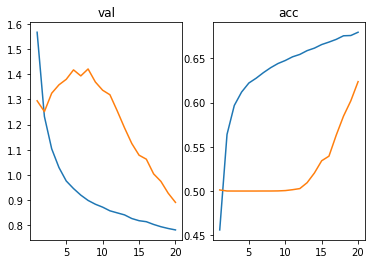

1752/1752 [==============================] - 6s 3ms/step - loss: 0.9077 - acc: 0.6164


In [67]:
for i in cnn_drop_out:
    for j in rnn_drop_out:
        model,lr=build_model3([32,32,32],[1,2,4],i,j)
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
        callback_list = [ModelCheckpoint(filepath='sentiment_rnn_checkpoint.h5',
                                 monitor='val_loss', 
                                 save_best_only=True), 
                 TensorBoard(log_dir="sentiment_rnn_logs/{}".format(
                     time.asctime()))]
        history = model.fit(X_train, y_train, 
                    batch_size=2048, epochs=20, 
                    validation_split=0.3, callbacks=callback_list)
        print("cnn_drop_out = ",i,"rnn_drop_out = ",j)
        fig=plt.figure()
        ax1=fig.add_subplot(1,2,1)
        ax2=fig.add_subplot(1,2,2)
        epochs = np.arange(1, 21)
        ax1.plot(epochs, history.history['loss'])
        ax1.plot(epochs, history.history['val_loss'])
        ax2.plot(epochs, history.history['acc'])
        ax2.plot(epochs, history.history['val_acc'])
        ax1.set_title('val')
        ax2.set_title('acc')
        plt.show()
        model.load_weights('sentiment_rnn_checkpoint.h5')
        model.evaluate(X_test, y_test)

In [77]:
num_filters=[[32,32,32],[64,64,64],[128,128,128]]
filter_sizes = [[1,2,3],[1,3,5],[1,2,4]]
mlp_dim = [50,100,150]
CNN_drop_out = [0.,0.1,0.2]

In [70]:
def build_model_CNN1(x,y,z,w):
    voca_dim = embedding_matrix.shape[0]
    time_steps = 50
    output_dim = 5
    rnn_dim = 100
    mlp_dim = z
    item_embedding = embedding_matrix
    rnn_depth=1
    mlp_depth = 2
    num_att_channel = 1
    cnn_drop_out = w
    rnn_drop_out = 0.
    rnn_state_drop_out = 0.
    trainable_embedding=False
    return_customized_layers=False
    num_filters = x
    filter_sizes = y
    mlp_drop_out = 0.2
    padding = 'causal'
    gpu=True
    
    return build_cnn_model(
        voca_dim, time_steps, output_dim, mlp_dim, num_filters ,filter_sizes,
        item_embedding=item_embedding, mlp_depth=mlp_depth,
        drop_out=0.5,cnn_drop_out=cnn_drop_out,pooling='max',padding='valid',
        trainable_embedding=trainable_embedding, return_customized_layers=return_customized_layers)

Epoch 1/20
35/35 [==============================] - 2s 55ms/step - loss: 1.7240 - acc: 0.3667 - val_loss: 1.3721 - val_acc: 0.4876
Epoch 2/20
35/35 [==============================] - 2s 49ms/step - loss: 1.1671 - acc: 0.5584 - val_loss: 0.9857 - val_acc: 0.6096
Epoch 3/20
35/35 [==============================] - 2s 49ms/step - loss: 0.9578 - acc: 0.6245 - val_loss: 1.0646 - val_acc: 0.5963
Epoch 4/20
35/35 [==============================] - 2s 49ms/step - loss: 0.8298 - acc: 0.6740 - val_loss: 1.1172 - val_acc: 0.5887
Epoch 5/20
35/35 [==============================] - 2s 49ms/step - loss: 0.7426 - acc: 0.7043 - val_loss: 1.2213 - val_acc: 0.5861
Epoch 6/20
35/35 [==============================] - 2s 49ms/step - loss: 0.6821 - acc: 0.7286 - val_loss: 1.2548 - val_acc: 0.5947
Epoch 7/20
35/35 [==============================] - 2s 49ms/step - loss: 0.6396 - acc: 0.7454 - val_loss: 1.3516 - val_acc: 0.5968
Epoch 8/20
35/35 [==============================] - 2s 49ms/step - loss: 0.5979 - a

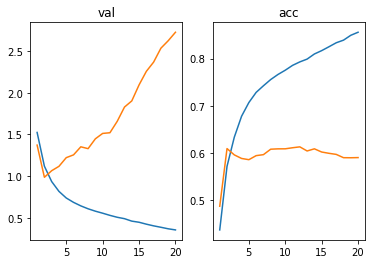

1752/1752 [==============================] - 3s 1ms/step - loss: 0.9983 - acc: 0.6056
Epoch 1/20
35/35 [==============================] - 2s 55ms/step - loss: 1.8009 - acc: 0.3568 - val_loss: 1.2341 - val_acc: 0.5400
Epoch 2/20
35/35 [==============================] - 2s 50ms/step - loss: 1.2443 - acc: 0.5324 - val_loss: 0.9755 - val_acc: 0.6118
Epoch 3/20
35/35 [==============================] - 2s 50ms/step - loss: 1.0392 - acc: 0.5963 - val_loss: 1.0215 - val_acc: 0.6061
Epoch 4/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9098 - acc: 0.6390 - val_loss: 1.0869 - val_acc: 0.5994
Epoch 5/20
35/35 [==============================] - 2s 50ms/step - loss: 0.8246 - acc: 0.6735 - val_loss: 1.1540 - val_acc: 0.5961
Epoch 6/20
35/35 [==============================] - 2s 50ms/step - loss: 0.7717 - acc: 0.6898 - val_loss: 1.1998 - val_acc: 0.5964
Epoch 7/20
35/35 [==============================] - 2s 50ms/step - loss: 0.7376 - acc: 0.7022 - val_loss: 1.2804 - val_acc: 0.59

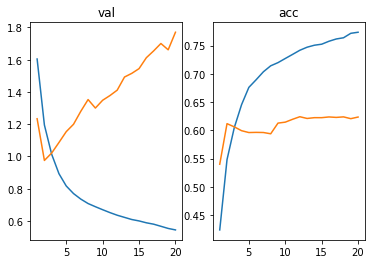

1752/1752 [==============================] - 3s 1ms/step - loss: 0.9924 - acc: 0.6036
Epoch 1/20
35/35 [==============================] - 2s 55ms/step - loss: 1.8420 - acc: 0.3287 - val_loss: 1.3914 - val_acc: 0.5015
Epoch 2/20
35/35 [==============================] - 2s 50ms/step - loss: 1.2818 - acc: 0.5121 - val_loss: 1.0105 - val_acc: 0.6011
Epoch 3/20
35/35 [==============================] - 2s 50ms/step - loss: 1.0784 - acc: 0.5783 - val_loss: 1.0035 - val_acc: 0.6148
Epoch 4/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9623 - acc: 0.6184 - val_loss: 1.0666 - val_acc: 0.6118
Epoch 5/20
35/35 [==============================] - 2s 50ms/step - loss: 0.8924 - acc: 0.6410 - val_loss: 1.1135 - val_acc: 0.6094
Epoch 6/20
35/35 [==============================] - 2s 50ms/step - loss: 0.8432 - acc: 0.6608 - val_loss: 1.1533 - val_acc: 0.6090
Epoch 7/20
35/35 [==============================] - 2s 50ms/step - loss: 0.8108 - acc: 0.6723 - val_loss: 1.2081 - val_acc: 0.60

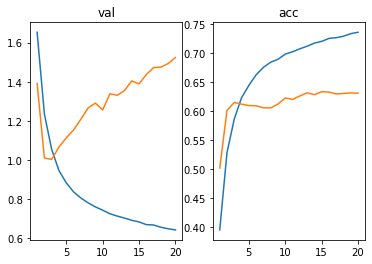

1752/1752 [==============================] - 3s 1ms/step - loss: 1.0194 - acc: 0.6082
Epoch 1/20
35/35 [==============================] - 2s 55ms/step - loss: 1.7537 - acc: 0.3906 - val_loss: 1.1518 - val_acc: 0.5741
Epoch 2/20
35/35 [==============================] - 2s 50ms/step - loss: 1.1452 - acc: 0.5738 - val_loss: 1.0056 - val_acc: 0.5927
Epoch 3/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9350 - acc: 0.6399 - val_loss: 1.1829 - val_acc: 0.5667
Epoch 4/20
35/35 [==============================] - 2s 50ms/step - loss: 0.7954 - acc: 0.6865 - val_loss: 1.2562 - val_acc: 0.5752
Epoch 5/20
35/35 [==============================] - 2s 50ms/step - loss: 0.7079 - acc: 0.7178 - val_loss: 1.2731 - val_acc: 0.5892
Epoch 6/20
35/35 [==============================] - 2s 50ms/step - loss: 0.6449 - acc: 0.7456 - val_loss: 1.4337 - val_acc: 0.5759
Epoch 7/20
35/35 [==============================] - 2s 50ms/step - loss: 0.6069 - acc: 0.7544 - val_loss: 1.3697 - val_acc: 0.60

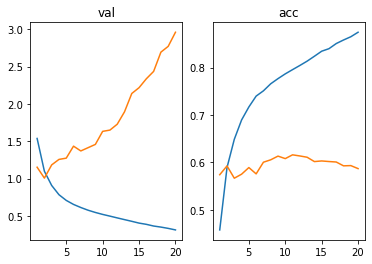

1752/1752 [==============================] - 3s 1ms/step - loss: 1.0158 - acc: 0.5896
Epoch 1/20
35/35 [==============================] - 2s 55ms/step - loss: 1.8034 - acc: 0.3753 - val_loss: 1.1424 - val_acc: 0.5669
Epoch 2/20
35/35 [==============================] - 2s 50ms/step - loss: 1.1990 - acc: 0.5529 - val_loss: 1.0038 - val_acc: 0.6087
Epoch 3/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9891 - acc: 0.6164 - val_loss: 1.0709 - val_acc: 0.6000
Epoch 4/20
35/35 [==============================] - 2s 50ms/step - loss: 0.8629 - acc: 0.6563 - val_loss: 1.1596 - val_acc: 0.5980
Epoch 5/20
35/35 [==============================] - 2s 50ms/step - loss: 0.8020 - acc: 0.6803 - val_loss: 1.1933 - val_acc: 0.5970
Epoch 6/20
35/35 [==============================] - 2s 50ms/step - loss: 0.7444 - acc: 0.6975 - val_loss: 1.2651 - val_acc: 0.5980
Epoch 7/20
35/35 [==============================] - 2s 50ms/step - loss: 0.7190 - acc: 0.7083 - val_loss: 1.2893 - val_acc: 0.60

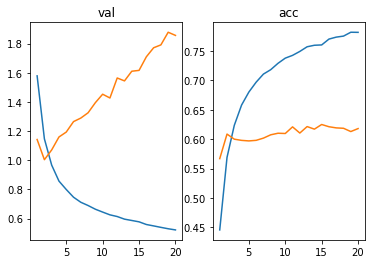

1752/1752 [==============================] - 3s 1ms/step - loss: 1.0197 - acc: 0.6004
Epoch 1/20
35/35 [==============================] - 2s 55ms/step - loss: 1.8103 - acc: 0.3717 - val_loss: 1.1374 - val_acc: 0.5802
Epoch 2/20
35/35 [==============================] - 2s 50ms/step - loss: 1.2571 - acc: 0.5376 - val_loss: 0.9721 - val_acc: 0.6087
Epoch 3/20
35/35 [==============================] - 2s 50ms/step - loss: 1.0476 - acc: 0.5920 - val_loss: 1.0845 - val_acc: 0.5936
Epoch 4/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9279 - acc: 0.6300 - val_loss: 1.2174 - val_acc: 0.5847
Epoch 5/20
35/35 [==============================] - 2s 50ms/step - loss: 0.8534 - acc: 0.6550 - val_loss: 1.2468 - val_acc: 0.5892
Epoch 6/20
35/35 [==============================] - 2s 50ms/step - loss: 0.8121 - acc: 0.6696 - val_loss: 1.2310 - val_acc: 0.5999
Epoch 7/20
35/35 [==============================] - 2s 50ms/step - loss: 0.7767 - acc: 0.6840 - val_loss: 1.3433 - val_acc: 0.59

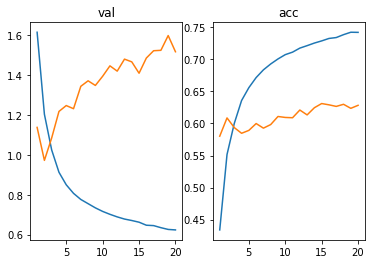

1752/1752 [==============================] - 3s 1ms/step - loss: 0.9883 - acc: 0.6011
Epoch 1/20
35/35 [==============================] - 2s 55ms/step - loss: 1.7320 - acc: 0.4046 - val_loss: 1.0961 - val_acc: 0.5861
Epoch 2/20
35/35 [==============================] - 2s 50ms/step - loss: 1.0915 - acc: 0.5915 - val_loss: 1.0917 - val_acc: 0.5785
Epoch 3/20
35/35 [==============================] - 2s 50ms/step - loss: 0.8890 - acc: 0.6528 - val_loss: 1.1745 - val_acc: 0.5752
Epoch 4/20
35/35 [==============================] - 2s 50ms/step - loss: 0.7674 - acc: 0.6951 - val_loss: 1.3080 - val_acc: 0.5692
Epoch 5/20
35/35 [==============================] - 2s 50ms/step - loss: 0.6804 - acc: 0.7260 - val_loss: 1.3597 - val_acc: 0.5771
Epoch 6/20
35/35 [==============================] - 2s 50ms/step - loss: 0.6267 - acc: 0.7495 - val_loss: 1.3191 - val_acc: 0.5955
Epoch 7/20
35/35 [==============================] - 2s 50ms/step - loss: 0.5856 - acc: 0.7628 - val_loss: 1.4289 - val_acc: 0.59

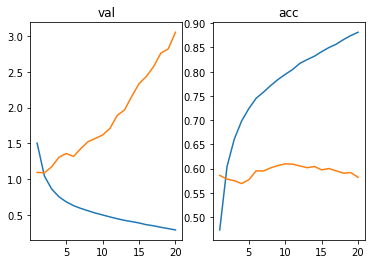

1752/1752 [==============================] - 3s 1ms/step - loss: 1.1075 - acc: 0.5743
Epoch 1/20
35/35 [==============================] - 2s 55ms/step - loss: 1.7398 - acc: 0.3891 - val_loss: 1.0431 - val_acc: 0.6018
Epoch 2/20
35/35 [==============================] - 2s 50ms/step - loss: 1.1491 - acc: 0.5656 - val_loss: 0.9776 - val_acc: 0.6118
Epoch 3/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9619 - acc: 0.6215 - val_loss: 1.0314 - val_acc: 0.6021
Epoch 4/20
35/35 [==============================] - 2s 50ms/step - loss: 0.8527 - acc: 0.6603 - val_loss: 1.0977 - val_acc: 0.6023
Epoch 5/20
35/35 [==============================] - 2s 50ms/step - loss: 0.7792 - acc: 0.6859 - val_loss: 1.1537 - val_acc: 0.6029
Epoch 6/20
35/35 [==============================] - 2s 50ms/step - loss: 0.7357 - acc: 0.7029 - val_loss: 1.2778 - val_acc: 0.5955
Epoch 7/20
35/35 [==============================] - 2s 50ms/step - loss: 0.6904 - acc: 0.7214 - val_loss: 1.3261 - val_acc: 0.60

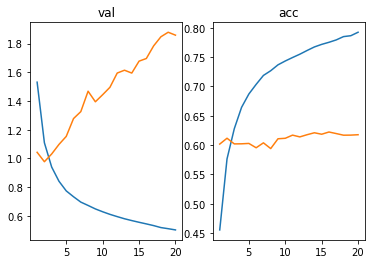

1752/1752 [==============================] - 3s 1ms/step - loss: 0.9847 - acc: 0.6087
Epoch 1/20
35/35 [==============================] - 2s 55ms/step - loss: 1.7720 - acc: 0.3874 - val_loss: 1.0716 - val_acc: 0.5931
Epoch 2/20
35/35 [==============================] - 2s 51ms/step - loss: 1.2123 - acc: 0.5488 - val_loss: 0.9883 - val_acc: 0.6089
Epoch 3/20
35/35 [==============================] - 2s 50ms/step - loss: 1.0203 - acc: 0.6016 - val_loss: 1.0321 - val_acc: 0.6037
Epoch 4/20
35/35 [==============================] - 2s 50ms/step - loss: 0.9126 - acc: 0.6331 - val_loss: 1.1289 - val_acc: 0.5979
Epoch 5/20
35/35 [==============================] - 2s 50ms/step - loss: 0.8534 - acc: 0.6567 - val_loss: 1.1553 - val_acc: 0.6026
Epoch 6/20
35/35 [==============================] - 2s 50ms/step - loss: 0.8040 - acc: 0.6745 - val_loss: 1.1980 - val_acc: 0.6064
Epoch 7/20
35/35 [==============================] - 2s 50ms/step - loss: 0.7780 - acc: 0.6825 - val_loss: 1.2303 - val_acc: 0.60

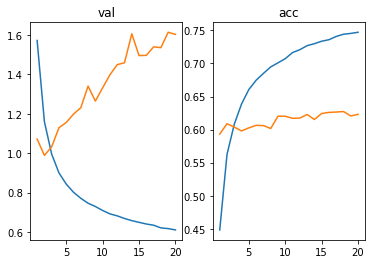

1752/1752 [==============================] - 3s 1ms/step - loss: 1.0000 - acc: 0.6003


In [78]:
for i in mlp_dim:
    for j in CNN_drop_out:
        model=build_model_CNN1([128,128,128],[1,3,5],i,j)
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
        callback_list = [ModelCheckpoint(filepath='sentiment_rnn_checkpoint.h5',
                                 monitor='val_loss', 
                                 save_best_only=True), 
                 TensorBoard(log_dir="sentiment_rnn_logs/{}".format(
                     time.asctime()))]
        history = model.fit(X_train, y_train, 
                    batch_size=2048, epochs=20, 
                    validation_split=0.3, callbacks=callback_list)
        print("mlp_dim = ",i,"CNN_drop_out = ",j)
        fig=plt.figure()
        ax1=fig.add_subplot(1,2,1)
        ax2=fig.add_subplot(1,2,2)
        epochs = np.arange(1, 21)
        ax1.plot(epochs, history.history['loss'])
        ax1.plot(epochs, history.history['val_loss'])
        ax2.plot(epochs, history.history['acc'])
        ax2.plot(epochs, history.history['val_acc'])
        ax1.set_title('val')
        ax2.set_title('acc')
        plt.show()
        model.load_weights('sentiment_rnn_checkpoint.h5')
        model.evaluate(X_test, y_test)

In [82]:
num_filters=[[32,32,32],[64,64,64],[128,128,128]]
filter_sizes = [[1,2,3],[1,3,5],[1,2,4]]
mlp_dim = [50,100,150]
rnn_dim = [50,100,150]

In [83]:
def build_model_RNN(x,y,z,w):
    voca_dim = embedding_matrix.shape[0]
    time_steps = 50
    output_dim = 5
    rnn_dim = w
    mlp_dim = z
    item_embedding = embedding_matrix
    rnn_depth=1
    mlp_depth = 2
    num_att_channel = 1
    cnn_drop_out = 0.5
    rnn_drop_out = 0.
    rnn_state_drop_out = 0.
    trainable_embedding=False
    return_customized_layers=False
    num_filters = x
    filter_sizes = y
    mlp_drop_out = 0.2
    padding = 'causal'
    gpu=True
    
    return build_birnn_hierarchy_cnn_model(
        voca_dim, time_steps, output_dim, rnn_dim, mlp_dim, num_filters, filter_sizes, 
        dilation_rates=1, strides=1,
        item_embedding=item_embedding, rnn_depth=rnn_depth, mlp_depth=mlp_depth,
        drop_out=0.5, rnn_drop_out=rnn_drop_out, rnn_state_drop_out=rnn_state_drop_out, cnn_drop_out=0.5, pooling='max', padding=padding,
        trainable_embedding=trainable_embedding, gpu=gpu, return_customized_layers=return_customized_layers)

Epoch 1/20
35/35 [==============================] - 4s 74ms/step - loss: 2.0365 - acc: 0.2936 - val_loss: 1.3828 - val_acc: 0.5004
Epoch 2/20
35/35 [==============================] - 2s 57ms/step - loss: 1.4151 - acc: 0.4932 - val_loss: 2.4413 - val_acc: 0.5000
Epoch 3/20
35/35 [==============================] - 2s 57ms/step - loss: 1.2138 - acc: 0.5514 - val_loss: 3.2924 - val_acc: 0.5000
Epoch 4/20
35/35 [==============================] - 2s 57ms/step - loss: 1.0921 - acc: 0.5855 - val_loss: 3.8304 - val_acc: 0.5000
Epoch 5/20
35/35 [==============================] - 2s 58ms/step - loss: 1.0091 - acc: 0.6142 - val_loss: 4.0351 - val_acc: 0.5000
Epoch 6/20
35/35 [==============================] - 2s 58ms/step - loss: 0.9498 - acc: 0.6306 - val_loss: 3.9927 - val_acc: 0.5000
Epoch 7/20
35/35 [==============================] - 2s 57ms/step - loss: 0.8964 - acc: 0.6467 - val_loss: 4.0062 - val_acc: 0.5001
Epoch 8/20
35/35 [==============================] - 2s 58ms/step - loss: 0.8619 - a

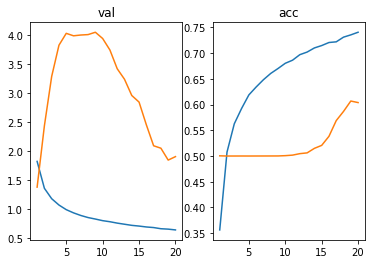

1752/1752 [==============================] - 6s 3ms/step - loss: 1.3940 - acc: 0.4966
Epoch 1/20
35/35 [==============================] - 5s 96ms/step - loss: 1.9907 - acc: 0.3073 - val_loss: 1.2789 - val_acc: 0.5032
Epoch 2/20
35/35 [==============================] - 3s 78ms/step - loss: 1.3912 - acc: 0.5020 - val_loss: 2.1857 - val_acc: 0.5012
Epoch 3/20
35/35 [==============================] - 3s 78ms/step - loss: 1.1790 - acc: 0.5653 - val_loss: 2.8453 - val_acc: 0.5038
Epoch 4/20
35/35 [==============================] - 3s 78ms/step - loss: 1.0631 - acc: 0.5978 - val_loss: 3.3790 - val_acc: 0.5005
Epoch 5/20
35/35 [==============================] - 3s 78ms/step - loss: 0.9742 - acc: 0.6219 - val_loss: 3.6141 - val_acc: 0.5009
Epoch 6/20
35/35 [==============================] - 3s 78ms/step - loss: 0.9180 - acc: 0.6395 - val_loss: 3.6588 - val_acc: 0.5029
Epoch 7/20
35/35 [==============================] - 3s 78ms/step - loss: 0.8820 - acc: 0.6510 - val_loss: 3.7926 - val_acc: 0.50

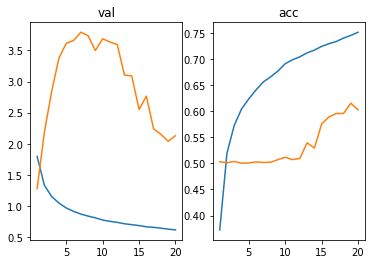

1752/1752 [==============================] - 6s 3ms/step - loss: 1.2896 - acc: 0.4989
Epoch 1/20
35/35 [==============================] - 6s 119ms/step - loss: 2.0609 - acc: 0.3057 - val_loss: 1.5581 - val_acc: 0.5003
Epoch 2/20
35/35 [==============================] - 4s 103ms/step - loss: 1.4119 - acc: 0.5037 - val_loss: 2.5967 - val_acc: 0.5015
Epoch 3/20
35/35 [==============================] - 4s 103ms/step - loss: 1.1907 - acc: 0.5606 - val_loss: 3.3387 - val_acc: 0.5004
Epoch 4/20
35/35 [==============================] - 4s 103ms/step - loss: 1.0695 - acc: 0.6001 - val_loss: 3.6181 - val_acc: 0.5000
Epoch 5/20
35/35 [==============================] - 4s 103ms/step - loss: 0.9966 - acc: 0.6195 - val_loss: 3.7061 - val_acc: 0.5002
Epoch 6/20
35/35 [==============================] - 4s 103ms/step - loss: 0.9406 - acc: 0.6380 - val_loss: 3.7810 - val_acc: 0.5003
Epoch 7/20
35/35 [==============================] - 4s 103ms/step - loss: 0.8799 - acc: 0.6532 - val_loss: 3.8701 - val_ac

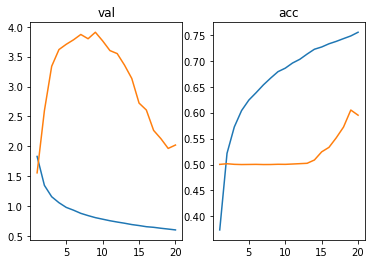

1752/1752 [==============================] - 6s 3ms/step - loss: 1.5714 - acc: 0.4965
Epoch 1/20
35/35 [==============================] - 6s 77ms/step - loss: 1.9857 - acc: 0.3093 - val_loss: 1.3168 - val_acc: 0.5008
Epoch 2/20
35/35 [==============================] - 2s 58ms/step - loss: 1.3531 - acc: 0.5237 - val_loss: 2.3073 - val_acc: 0.5001
Epoch 3/20
35/35 [==============================] - 2s 58ms/step - loss: 1.1254 - acc: 0.5905 - val_loss: 2.8917 - val_acc: 0.5000
Epoch 4/20
35/35 [==============================] - 2s 58ms/step - loss: 1.0169 - acc: 0.6162 - val_loss: 3.2060 - val_acc: 0.5000
Epoch 5/20
35/35 [==============================] - 2s 58ms/step - loss: 0.9491 - acc: 0.6312 - val_loss: 3.2152 - val_acc: 0.5000
Epoch 6/20
35/35 [==============================] - 2s 58ms/step - loss: 0.9035 - acc: 0.6398 - val_loss: 3.3503 - val_acc: 0.5002
Epoch 7/20
35/35 [==============================] - 2s 58ms/step - loss: 0.8699 - acc: 0.6526 - val_loss: 3.5066 - val_acc: 0.50

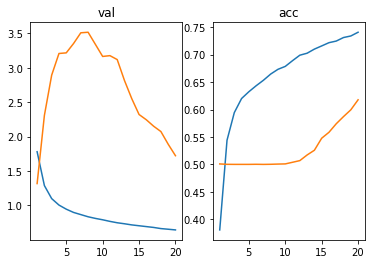

1752/1752 [==============================] - 6s 3ms/step - loss: 1.3294 - acc: 0.4970
Epoch 1/20
35/35 [==============================] - 5s 97ms/step - loss: 1.8899 - acc: 0.3428 - val_loss: 1.3391 - val_acc: 0.5055
Epoch 2/20
35/35 [==============================] - 3s 78ms/step - loss: 1.3029 - acc: 0.5317 - val_loss: 2.3321 - val_acc: 0.5005
Epoch 3/20
35/35 [==============================] - 3s 78ms/step - loss: 1.1143 - acc: 0.5829 - val_loss: 3.1197 - val_acc: 0.5004
Epoch 4/20
35/35 [==============================] - 3s 79ms/step - loss: 0.9996 - acc: 0.6158 - val_loss: 3.5521 - val_acc: 0.5002
Epoch 5/20
35/35 [==============================] - 3s 79ms/step - loss: 0.9327 - acc: 0.6377 - val_loss: 3.8029 - val_acc: 0.5001
Epoch 6/20
35/35 [==============================] - 3s 78ms/step - loss: 0.8738 - acc: 0.6558 - val_loss: 4.0196 - val_acc: 0.5002
Epoch 7/20
35/35 [==============================] - 3s 78ms/step - loss: 0.8378 - acc: 0.6680 - val_loss: 4.0543 - val_acc: 0.50

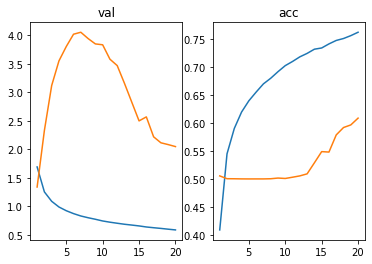

1752/1752 [==============================] - 6s 3ms/step - loss: 1.3520 - acc: 0.5011
Epoch 1/20
35/35 [==============================] - 6s 121ms/step - loss: 1.9507 - acc: 0.3464 - val_loss: 1.3988 - val_acc: 0.5060
Epoch 2/20
35/35 [==============================] - 4s 103ms/step - loss: 1.3020 - acc: 0.5456 - val_loss: 2.9606 - val_acc: 0.5006
Epoch 3/20
35/35 [==============================] - 4s 103ms/step - loss: 1.1065 - acc: 0.5933 - val_loss: 3.9960 - val_acc: 0.5011
Epoch 4/20
35/35 [==============================] - 4s 103ms/step - loss: 1.0052 - acc: 0.6179 - val_loss: 4.5301 - val_acc: 0.5006
Epoch 5/20
35/35 [==============================] - 4s 103ms/step - loss: 0.9304 - acc: 0.6393 - val_loss: 4.4647 - val_acc: 0.5013
Epoch 6/20
35/35 [==============================] - 4s 103ms/step - loss: 0.8731 - acc: 0.6560 - val_loss: 4.4844 - val_acc: 0.5015
Epoch 7/20
35/35 [==============================] - 4s 103ms/step - loss: 0.8318 - acc: 0.6666 - val_loss: 4.4446 - val_ac

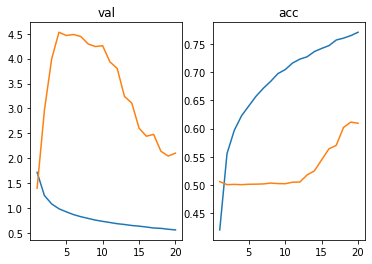

1752/1752 [==============================] - 6s 3ms/step - loss: 1.4131 - acc: 0.5012
Epoch 1/20
35/35 [==============================] - 4s 77ms/step - loss: 1.9836 - acc: 0.3258 - val_loss: 1.2832 - val_acc: 0.5042
Epoch 2/20
35/35 [==============================] - 2s 58ms/step - loss: 1.3530 - acc: 0.5164 - val_loss: 2.1560 - val_acc: 0.5008
Epoch 3/20
35/35 [==============================] - 2s 58ms/step - loss: 1.1232 - acc: 0.5858 - val_loss: 2.8688 - val_acc: 0.5002
Epoch 4/20
35/35 [==============================] - 2s 58ms/step - loss: 1.0101 - acc: 0.6141 - val_loss: 3.3316 - val_acc: 0.5005
Epoch 5/20
35/35 [==============================] - 2s 58ms/step - loss: 0.9409 - acc: 0.6294 - val_loss: 3.5809 - val_acc: 0.5001
Epoch 6/20
35/35 [==============================] - 2s 58ms/step - loss: 0.8886 - acc: 0.6473 - val_loss: 3.6496 - val_acc: 0.5005
Epoch 7/20
35/35 [==============================] - 2s 58ms/step - loss: 0.8547 - acc: 0.6594 - val_loss: 3.6640 - val_acc: 0.50

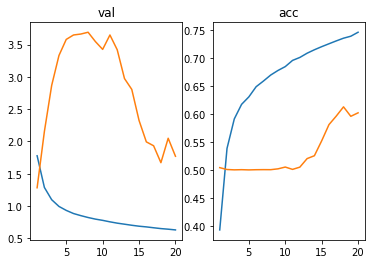

1752/1752 [==============================] - 6s 3ms/step - loss: 1.2953 - acc: 0.4991
Epoch 1/20
35/35 [==============================] - 5s 97ms/step - loss: 1.9411 - acc: 0.3462 - val_loss: 1.4019 - val_acc: 0.5017
Epoch 2/20
35/35 [==============================] - 3s 79ms/step - loss: 1.2919 - acc: 0.5389 - val_loss: 2.7011 - val_acc: 0.5002
Epoch 3/20
35/35 [==============================] - 3s 79ms/step - loss: 1.0873 - acc: 0.5942 - val_loss: 3.4904 - val_acc: 0.5001
Epoch 4/20
35/35 [==============================] - 3s 78ms/step - loss: 0.9883 - acc: 0.6190 - val_loss: 4.2990 - val_acc: 0.5000
Epoch 5/20
35/35 [==============================] - 3s 78ms/step - loss: 0.9128 - acc: 0.6398 - val_loss: 4.5759 - val_acc: 0.5000
Epoch 6/20
35/35 [==============================] - 3s 79ms/step - loss: 0.8669 - acc: 0.6552 - val_loss: 4.8789 - val_acc: 0.5000
Epoch 7/20
35/35 [==============================] - 3s 79ms/step - loss: 0.8298 - acc: 0.6680 - val_loss: 5.1030 - val_acc: 0.50

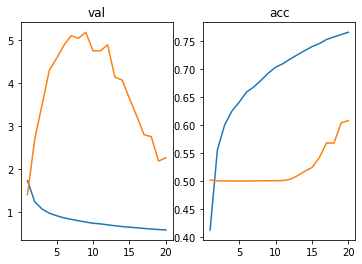

1752/1752 [==============================] - 6s 3ms/step - loss: 1.4133 - acc: 0.4979
Epoch 1/20
35/35 [==============================] - 6s 119ms/step - loss: 1.9480 - acc: 0.3514 - val_loss: 1.3223 - val_acc: 0.5038
Epoch 2/20
35/35 [==============================] - 4s 103ms/step - loss: 1.2964 - acc: 0.5417 - val_loss: 2.4160 - val_acc: 0.5030
Epoch 3/20
35/35 [==============================] - 4s 103ms/step - loss: 1.1057 - acc: 0.5870 - val_loss: 3.2181 - val_acc: 0.5039
Epoch 4/20
35/35 [==============================] - 4s 103ms/step - loss: 0.9972 - acc: 0.6162 - val_loss: 3.7131 - val_acc: 0.5014
Epoch 5/20
35/35 [==============================] - 4s 103ms/step - loss: 0.9256 - acc: 0.6333 - val_loss: 3.9529 - val_acc: 0.5014
Epoch 6/20
35/35 [==============================] - 4s 103ms/step - loss: 0.8767 - acc: 0.6512 - val_loss: 4.1868 - val_acc: 0.5014
Epoch 7/20
35/35 [==============================] - 4s 103ms/step - loss: 0.8304 - acc: 0.6705 - val_loss: 4.0710 - val_ac

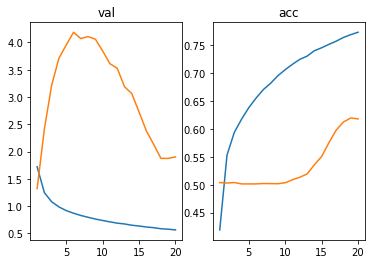

1752/1752 [==============================] - 6s 3ms/step - loss: 1.3360 - acc: 0.4992


In [85]:
for i in mlp_dim:
    for j in rnn_dim:
        model=build_model_RNN([64,64,64],[1,3,5],i,j)
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
        callback_list = [ModelCheckpoint(filepath='sentiment_rnn_checkpoint.h5',
                                 monitor='val_loss', 
                                 save_best_only=True), 
                 TensorBoard(log_dir="sentiment_rnn_logs/{}".format(
                     time.asctime()))]
        history = model.fit(X_train, y_train, 
                    batch_size=2048, epochs=20, 
                    validation_split=0.3, callbacks=callback_list)
        print("mlp_dim = ",i,"rnn_dim = ",j)
        fig=plt.figure()
        ax1=fig.add_subplot(1,2,1)
        ax2=fig.add_subplot(1,2,2)
        epochs = np.arange(1, 21)
        ax1.plot(epochs, history.history['loss'])
        ax1.plot(epochs, history.history['val_loss'])
        ax2.plot(epochs, history.history['acc'])
        ax2.plot(epochs, history.history['val_acc'])
        ax1.set_title('val')
        ax2.set_title('acc')
        plt.show()
        model.load_weights('sentiment_rnn_checkpoint.h5')
        model.evaluate(X_test, y_test)

In [86]:
model=build_model_RNN([64,64,64],[1,3,5],150,100)

In [87]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [88]:
callback_list = [ModelCheckpoint(filepath='sentiment_rnn_checkpoint.h5',
                                 monitor='val_loss', 
                                 save_best_only=True), 
                 TensorBoard(log_dir="sentiment_rnn_logs/{}".format(
                     time.asctime()))]

Epoch 1/100
35/35 [==============================] - 5s 94ms/step - loss: 1.9796 - acc: 0.3169 - val_loss: 1.3712 - val_acc: 0.5021
Epoch 2/100
35/35 [==============================] - 3s 78ms/step - loss: 1.3120 - acc: 0.5244 - val_loss: 2.1735 - val_acc: 0.5010
Epoch 3/100
35/35 [==============================] - 3s 78ms/step - loss: 1.1087 - acc: 0.5834 - val_loss: 2.6787 - val_acc: 0.5010
Epoch 4/100
35/35 [==============================] - 3s 78ms/step - loss: 1.0046 - acc: 0.6117 - val_loss: 3.0845 - val_acc: 0.5008
Epoch 5/100
35/35 [==============================] - 3s 78ms/step - loss: 0.9464 - acc: 0.6288 - val_loss: 3.1889 - val_acc: 0.5012
Epoch 6/100
35/35 [==============================] - 3s 78ms/step - loss: 0.8932 - acc: 0.6442 - val_loss: 3.3869 - val_acc: 0.5010
Epoch 7/100
35/35 [==============================] - 3s 78ms/step - loss: 0.8573 - acc: 0.6583 - val_loss: 3.3105 - val_acc: 0.5015
Epoch 8/100
35/35 [==============================] - 3s 78ms/step - loss: 0.

35/35 [==============================] - 3s 79ms/step - loss: 0.2463 - acc: 0.9102 - val_loss: 4.5481 - val_acc: 0.5730
Epoch 63/100
35/35 [==============================] - 3s 78ms/step - loss: 0.2368 - acc: 0.9122 - val_loss: 4.7155 - val_acc: 0.5728
Epoch 64/100
35/35 [==============================] - 3s 79ms/step - loss: 0.2444 - acc: 0.9093 - val_loss: 4.4207 - val_acc: 0.5677
Epoch 65/100
35/35 [==============================] - 3s 79ms/step - loss: 0.2429 - acc: 0.9094 - val_loss: 4.4730 - val_acc: 0.5703
Epoch 66/100
35/35 [==============================] - 3s 79ms/step - loss: 0.2264 - acc: 0.9178 - val_loss: 5.0401 - val_acc: 0.5654
Epoch 67/100
35/35 [==============================] - 3s 79ms/step - loss: 0.2190 - acc: 0.9187 - val_loss: 5.0398 - val_acc: 0.5569
Epoch 68/100
35/35 [==============================] - 3s 79ms/step - loss: 0.2191 - acc: 0.9202 - val_loss: 4.8000 - val_acc: 0.5562
Epoch 69/100
35/35 [==============================] - 3s 79ms/step - loss: 0.2233 

ValueError: x and y must have same first dimension, but have shapes (20,) and (100,)

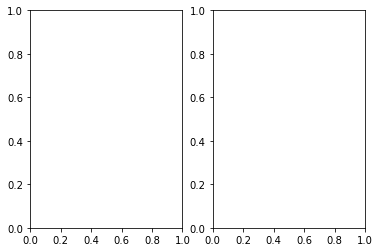

In [89]:
history = model.fit(X_train, y_train, 
                    batch_size=2048, epochs=100, 
                    validation_split=0.3, callbacks=callback_list)


mlp_dim =  150 rnn_dim =  150


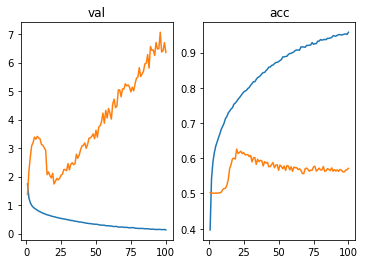

1752/1752 [==============================] - 6s 3ms/step - loss: 1.3846 - acc: 0.4975


[1.38461172580719, 0.4974670112133026]

In [90]:
print("mlp_dim = ",i,"rnn_dim = ",j)
fig=plt.figure()
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
epochs = np.arange(1, 101)
ax1.plot(epochs, history.history['loss'])
ax1.plot(epochs, history.history['val_loss'])
ax2.plot(epochs, history.history['acc'])
ax2.plot(epochs, history.history['val_acc'])
ax1.set_title('val')
ax2.set_title('acc')
plt.show()
model.load_weights('sentiment_rnn_checkpoint.h5')
model.evaluate(X_test, y_test)